# FEATURE EXTRACTION EXAMPLE FOR IMPEDANCE OF A PARTICIPANT

In [1]:
import pandas as pd
#we first read in a data set of one participant as an example
#it contains the raw impedance data coming from VU-AMS 5fs
#it also contains a column called Task_Label_2 which includes our task labels for the procedure

#data can also be read in another format as long as it is turned into a pandas dataframe format

#the dataframe should not be datetime indexed. if it is, drop the indexes before following with the next cells

#Note that we multiplied all points of the raw data for VU-AMS 5fs impedance by 1000000. The original Z0 values given
#are always positive so the actual signal properties remain unchanged. It is simply shifted upwards. 
#It is multiplied with this factor before feature extraction because the original values have a very small magnitude (1-10 ohms)
#which causes the scipy peak detection function to give errors after filtering. 
#Because we do this multiplication, and then filter and extract the features, at the end we will divide all amplitude
#related features by 1000000. (we receive the same results if, for instance, we multiply with 10000 in the beginning
#and divide by 10000 at the end)

df_impedance = pd.read_hdf('df_impedance.h5', 'df_impedance')
df_impedance

RSP_Raw Task_Label_2
0       8.791453e+06          NaN
1       8.782418e+06          NaN
2       8.782418e+06          NaN
3       8.773382e+06          NaN
4       8.764347e+06          NaN
...              ...          ...
937496  7.083761e+06         94.0
937497  7.083761e+06         94.0
937498  7.083761e+06         94.0
937499  7.092796e+06         94.0
937500  7.092796e+06          NaN

[937501 rows x 2 columns]

In [2]:
#below, we are customizing the steps of respiration processing and defining the function via neurokit2
#the main steps include cleaning and identification of troughs and peaks
def my_cleaning(rsp_signal, sampling_rate):
    # My custom cleaning logic
    cleaned = nk.signal_filter(
        rsp_signal,
        sampling_rate=sampling_rate,
        lowcut=0.05,
        highcut=0.55,
        order=2,
        method='butterworth'
    )
    return cleaned

import pandas as pd

from neurokit2 import as_vector
from neurokit2 import signal_rate
from neurokit2 import rsp_amplitude
from neurokit2 import rsp_clean
from neurokit2 import rsp_methods
from neurokit2 import rsp_peaks
from neurokit2 import rsp_phase
from neurokit2 import rsp_plot
from neurokit2 import rsp_rvt
from neurokit2 import rsp_symmetry

def my_process_impedance(
    rsp_signal,
    sampling_rate=250,
    method="scipy",
    method_rvt="harrison2021",
    report=None,
    **kwargs
):
    """**Process a respiration (RSP) signal**

    Convenience function that automatically processes a respiration signal with one of the
    following methods:

    * `Khodadad et al. (2018) <https://iopscience.iop.org/article/10.1088/1361-6579/aad7e6/meta>`_

    * `BioSPPy <https://github.com/PIA-Group/BioSPPy/blob/master/biosppy/signals/resp.py>`_

    Parameters
    ----------
    rsp_signal : Union[list, np.array, pd.Series]
        The raw respiration channel (as measured, for instance, by a respiration belt).
    sampling_rate : int
        The sampling frequency of :func:`.rsp_signal` (in Hz, i.e., samples/second).
    method : str
        The processing pipeline to apply. Can be one of ``"khodadad2018"`` (default)
        or ``"biosppy"``.
    method_rvt : str
        The rvt method to apply. Can be one of ``"harrison2021"`` (default), ``"birn2006"``
        or ``"power2020"``.
    report : str
        The filename of a report containing description and figures of processing
        (e.g. ``"myreport.html"``). Needs to be supplied if a report file
        should be generated. Defaults to ``None``. Can also be ``"text"`` to
        just print the text in the console without saving anything.
    **kwargs
        Other arguments to be passed to specific methods. For more information,
        see :func:`.rsp_methods`.

    Returns
    -------
    signals : DataFrame
        A DataFrame of same length as :func:`.rsp_signal` containing the following columns:

        * ``"RSP_Raw"``: the raw signal.
        * ``"RSP_Clean"``: the cleaned signal.
        * ``"RSP_Peaks"``: the respiratory peaks (exhalation onsets) marked as "1" in a list of
          zeros.
        * ``"RSP_Troughs"``: the respiratory troughs (inhalation onsets) marked as "1" in a list of
          zeros.
        * ``"RSP_Rate"``: breathing rate interpolated between inhalation peaks.
        * ``"RSP_Amplitude"``: breathing amplitude interpolated between inhalation peaks.
        * ``"RSP_Phase"``: breathing phase, marked by "1" for inspiration and "0" for expiration.
        * ``"RSP_PhaseCompletion"``: breathing phase completion, expressed in percentage (from 0 to
          1), representing the stage of the current respiratory phase.
         * ``"RSP_RVT"``: respiratory volume per time (RVT).
    info : dict
        A dictionary containing the samples at which inhalation peaks and exhalation troughs occur,
        accessible with the keys ``"RSP_Peaks"``, and ``"RSP_Troughs"`` respectively, as well as the
        signals' sampling rate.

    See Also
    --------
    rsp_clean, rsp_findpeaks, .signal_rate, rsp_amplitude, rsp_plot, rsp_phase, rsp_rvt, rsp_symmetry

    Examples
    --------
    .. ipython:: python

      import neurokit2 as nk

      rsp = nk.rsp_simulate(duration=90, respiratory_rate=15)
      signals, info = nk.rsp_process(rsp, sampling_rate=250, report="text")

      @savefig p_rsp_process_1.png scale=100%
      fig = nk.rsp_plot(signals, sampling_rate=250)
      @suppress
      plt.close()

    """
    # sanitize input
    rsp_signal = as_vector(rsp_signal)
    methods = rsp_methods(
        sampling_rate=sampling_rate, method=method, method_rvt=method_rvt, **kwargs
    )

    # clean signal
    rsp_cleaned = my_cleaning(rsp_signal, sampling_rate=sampling_rate)

    # extract, fix and format peaks
    peak_signal, info = rsp_peaks(
        rsp_cleaned,
        sampling_rate=sampling_rate,
        method=methods["method_peaks"],
        peak_distance=1.65, 
        **methods["kwargs_peaks"]
    )
    
    info["sampling_rate"] = sampling_rate  # Add sampling rate in dict info

    # getting additional parameters
    phase = rsp_phase(peak_signal, desired_length=len(rsp_signal))
    amplitude = rsp_amplitude(rsp_cleaned, peak_signal)
    rate = signal_rate(
        info["RSP_Troughs"], sampling_rate=sampling_rate, desired_length=len(rsp_signal)
    )
    symmetry = rsp_symmetry(rsp_cleaned, peak_signal)
    rvt = rsp_rvt(
        rsp_cleaned,
        method=methods["method_rvt"],
        sampling_rate=sampling_rate,
        silent=True,
    )

    # preparing output
    signals = pd.DataFrame(
        {
            "RSP_Raw": rsp_signal,
            "RSP_Clean": rsp_cleaned,
            "RSP_Amplitude": amplitude,
            "RSP_Rate": rate,
            "RSP_RVT": rvt,
        }
    )
    signals = pd.concat([signals, phase, symmetry, peak_signal], axis=1)

    if report is not None:
       
        if ".html" in str(report):
            fig = rsp_plot(signals, sampling_rate=sampling_rate)
        else:
            fig = None
        create_report(file=report, signals=signals, info=methods, fig=fig)

    return signals, info


In [3]:
#below, we define a function which will, for each of the task names we enter, clean the segments of interest and do
#peak trough detection within the 30-sec segment entered along with the 5 seconds before and after each segment
#it creates a new dataframe per segment with RSP_Raw (stays same), RSP_Cleaned, and RSP_Peaks, RSP_Troughs
#Whenever there is a peak, RSP_Peaks = 1, and whenever there is a trough, RSP_Troughs = 1

#the function also visualizes the cleaned segments with the peak and troughs
import matplotlib.pyplot as plt
import neurokit2 as nk
def process_and_visualize_impedance(shiftedimp_data, participant_id, tasks):
    # segmenting the larger dataframe into task-specific dataframes
    tasks_dataframes_impedance = {}
    for task in tasks:
        task_indices = shiftedimp_data[shiftedimp_data['Task_Label_2'] == task].index
        if not task_indices.empty:
            start_index = task_indices[0] - 1750
            end_index = task_indices[-1] + 1750
            start_index = max(start_index, 0)
            end_index = min(end_index, len(shiftedimp_data) - 1)
            task_dataframe = shiftedimp_data.loc[start_index:end_index, ['RSP_Raw', 'Task_Label_2']]
            tasks_dataframes_impedance[task] = task_dataframe

    # processing each task-specific dataframe
    processed_tasks_dataframes_impedance = {}
    for task, task_df in tasks_dataframes_impedance.items():
        rsp_signal = task_df['RSP_Raw']
        processed_data, _ = my_process_impedance(rsp_signal, sampling_rate=250)
        processed_data.reset_index(drop=True, inplace=True)
        task_df_reset = task_df.reset_index(drop=True)
        processed_data_with_label = processed_data.merge(task_df_reset[['Task_Label_2']], left_index=True, right_index=True, how='left')
        processed_tasks_dataframes_impedance[task] = processed_data_with_label

        # visualizing segments of interest
        task_specific_indices = processed_data_with_label.index[processed_data_with_label['Task_Label_2'] == task]
        if not task_specific_indices.empty:
            task_start = task_specific_indices[0]
            task_end = task_specific_indices[-1]
            plt.figure(figsize=(15, 4))
            plt.plot(processed_data_with_label.loc[task_start:task_end, 'RSP_Clean'], label='RSP_Clean', color='black')
            peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
            troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index
            for peak in peaks:
                plt.axvline(x=peak, color='red', linestyle='--', alpha=0.7)
            for trough in troughs:
                plt.axvline(x=trough, color='blue', linestyle='--', alpha=0.7)
            plt.title(f"Participant {participant_id}, Task: {task}")
            plt.xlabel("Samples")
            plt.ylabel("RSP_Clean")
            plt.legend()
            plt.show()
    
    # returning the processed dataframes
    return processed_tasks_dataframes_impedance



C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


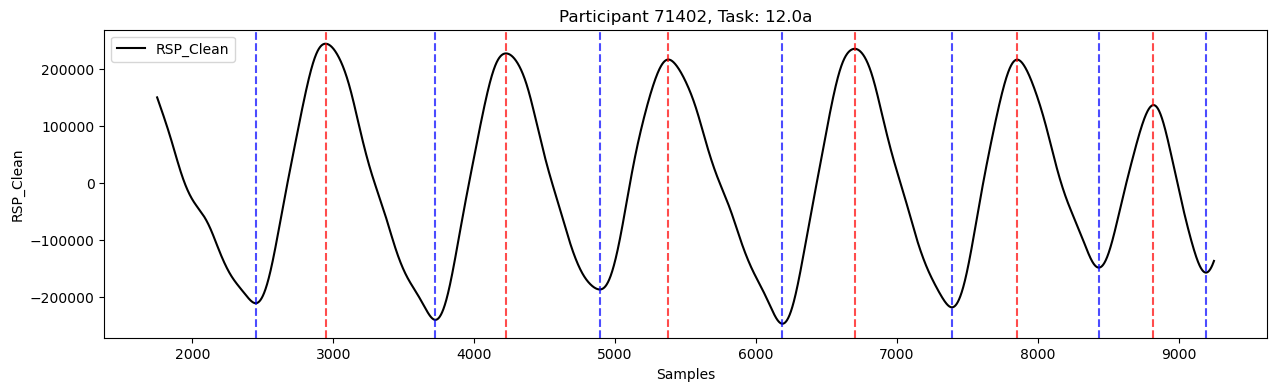

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


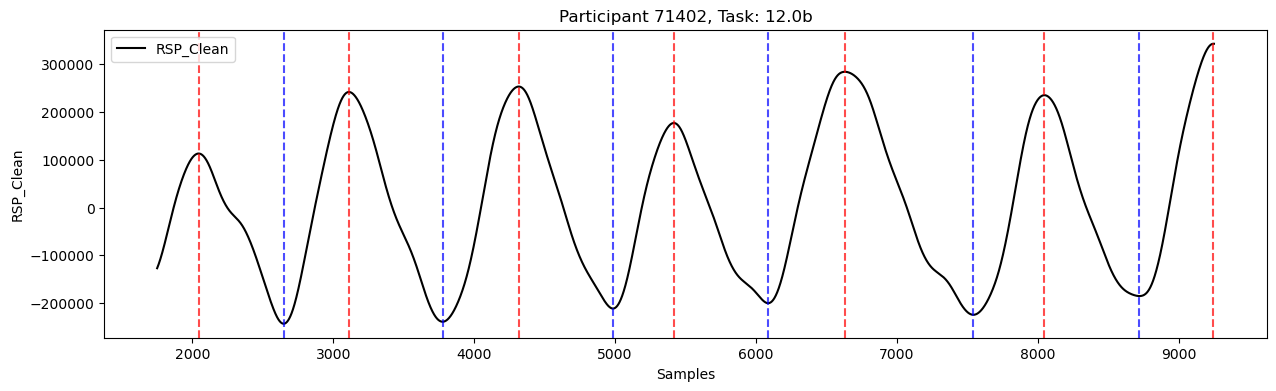

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


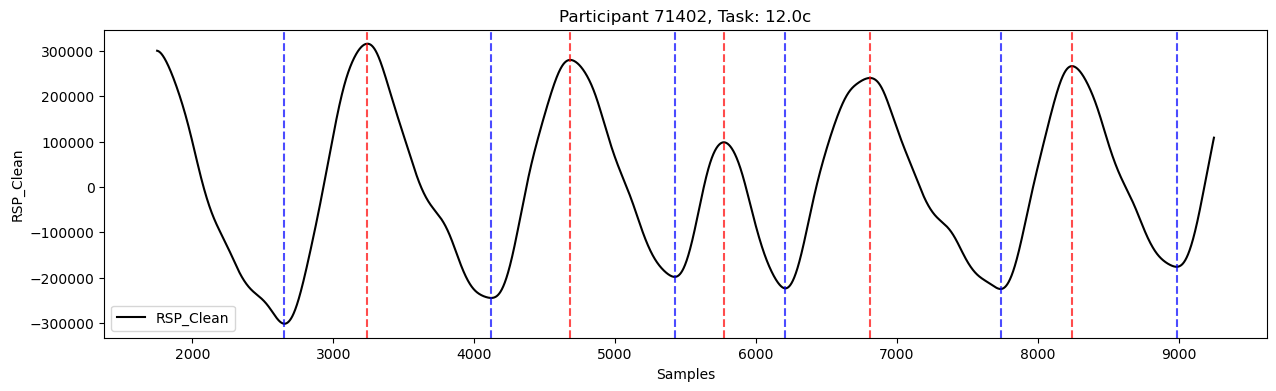

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


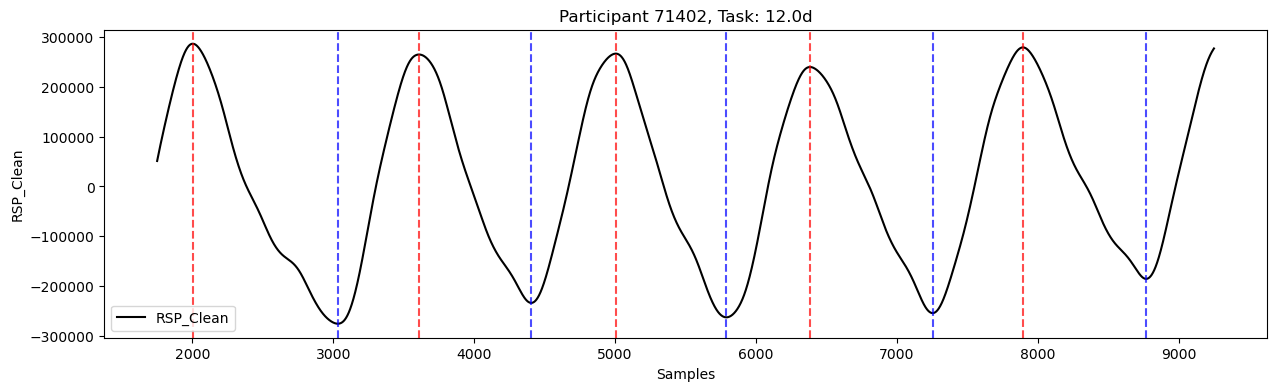

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


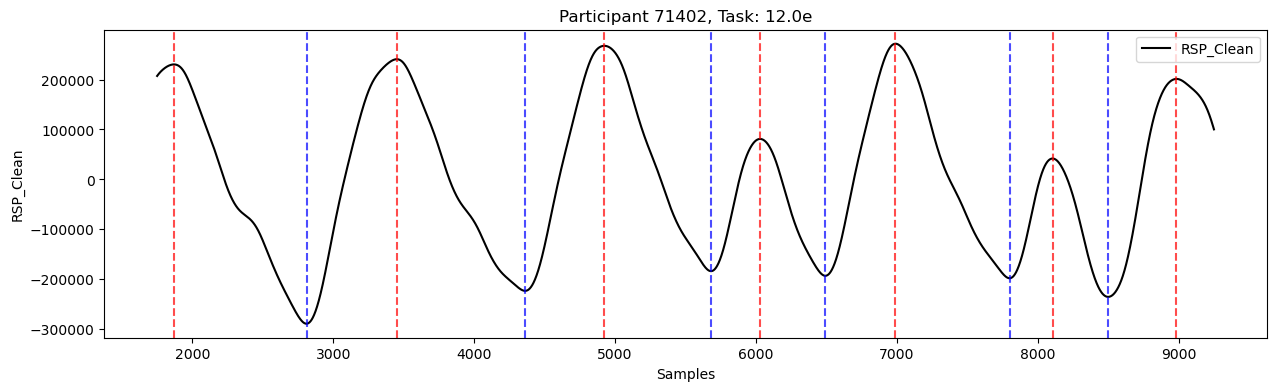

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


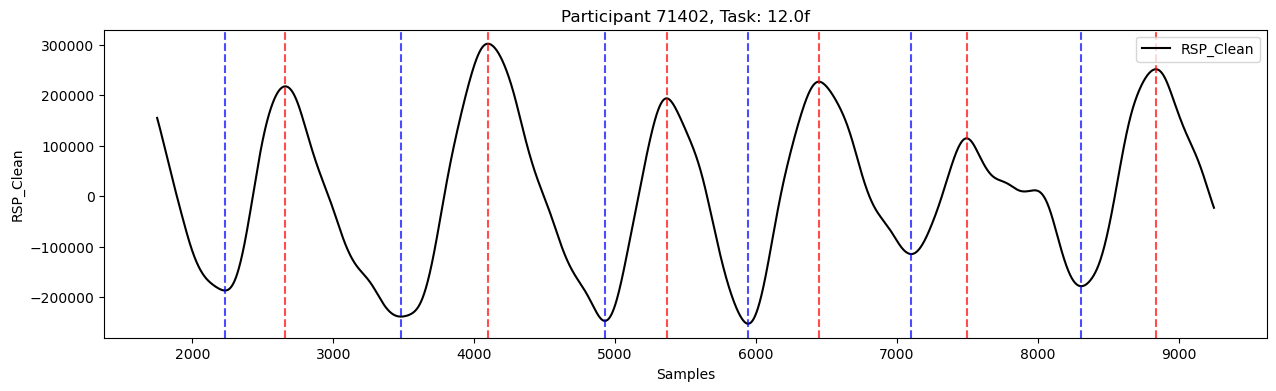

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


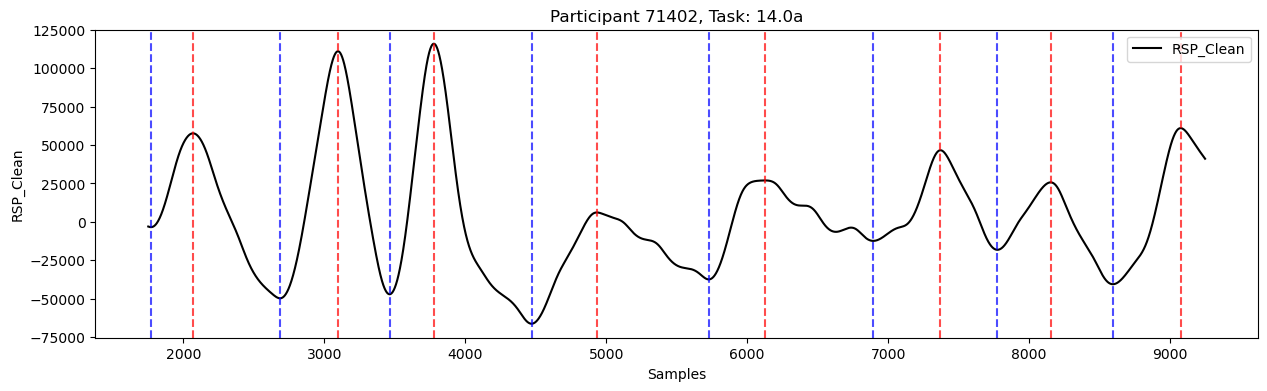

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


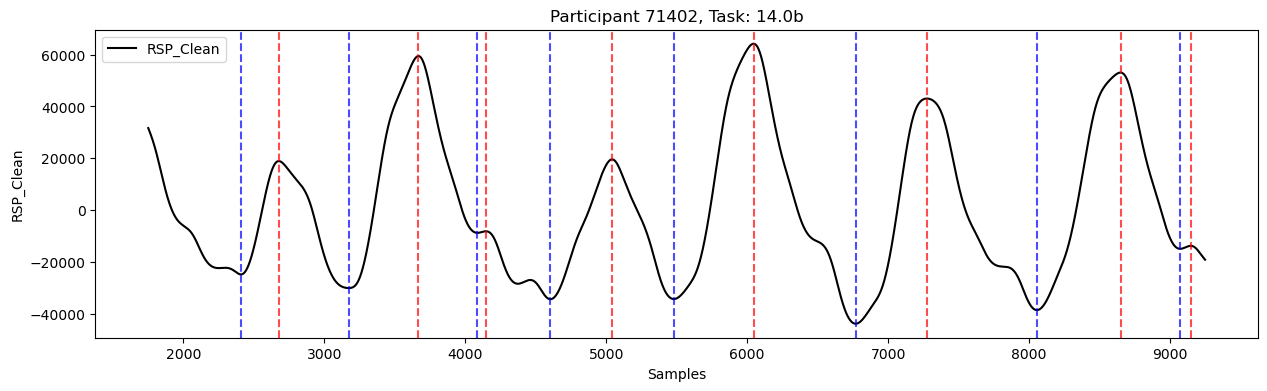

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


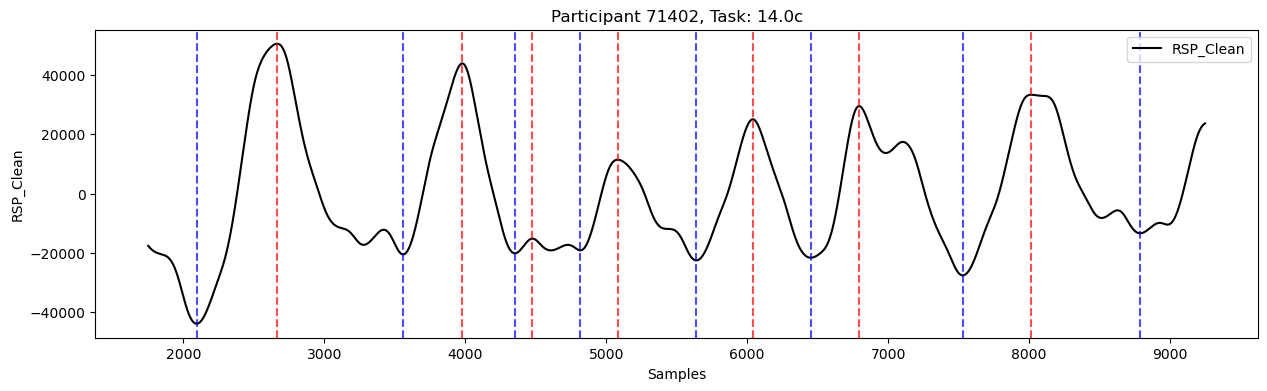

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


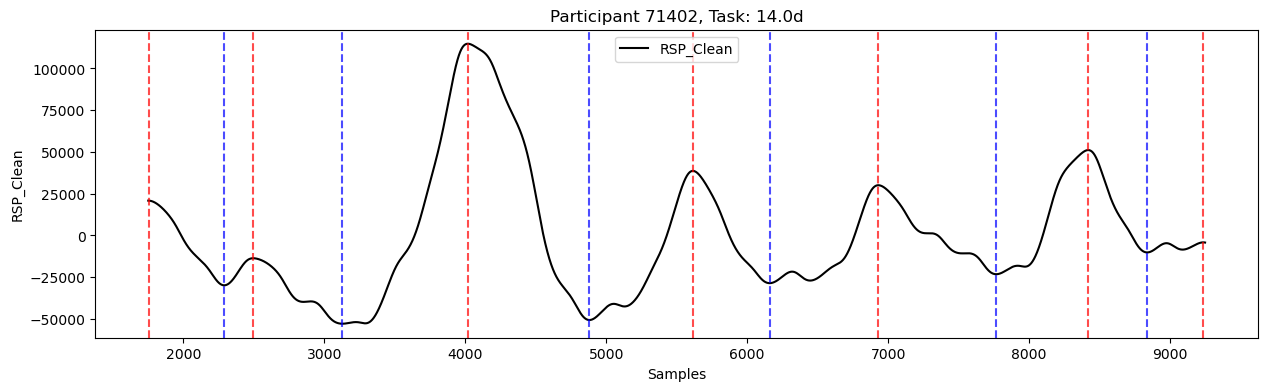

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


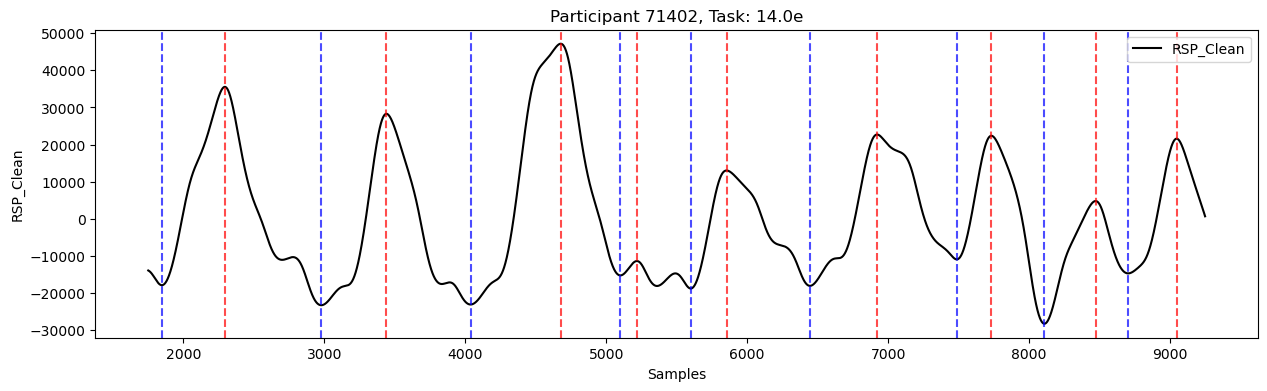

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


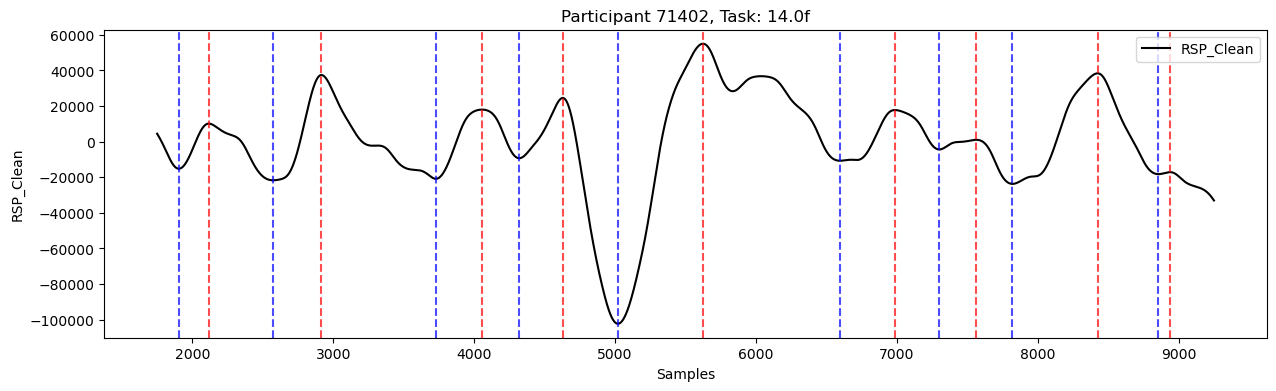

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


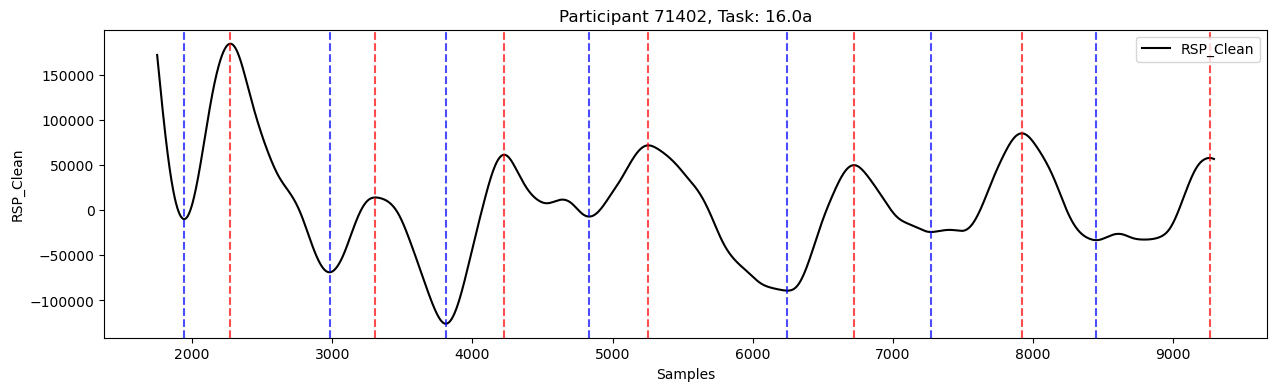

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


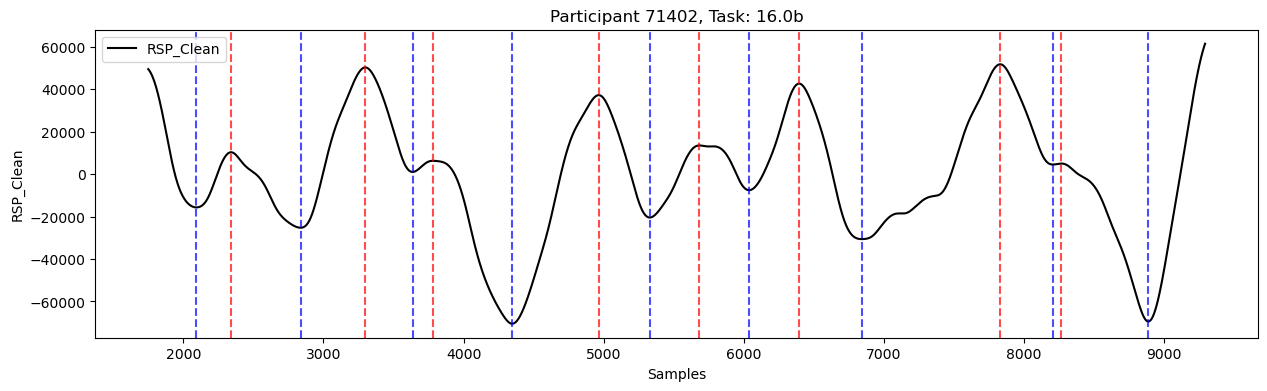

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


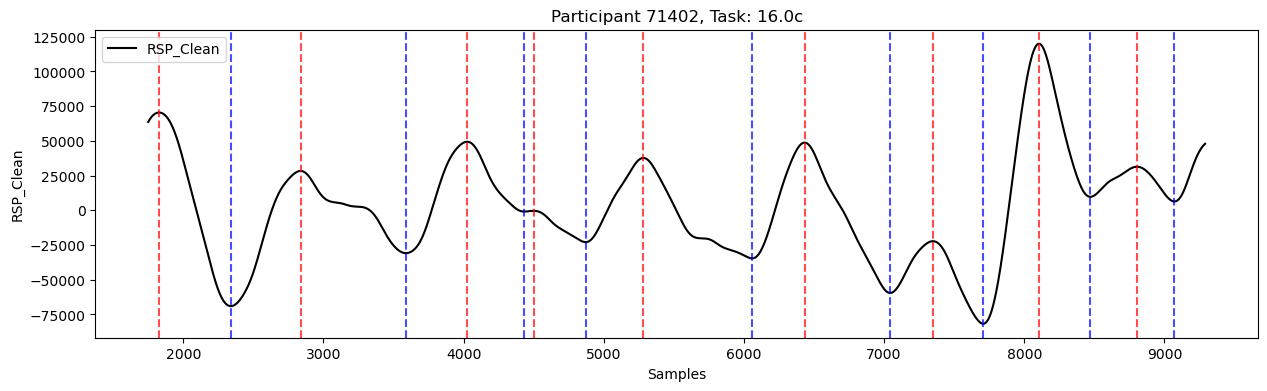

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


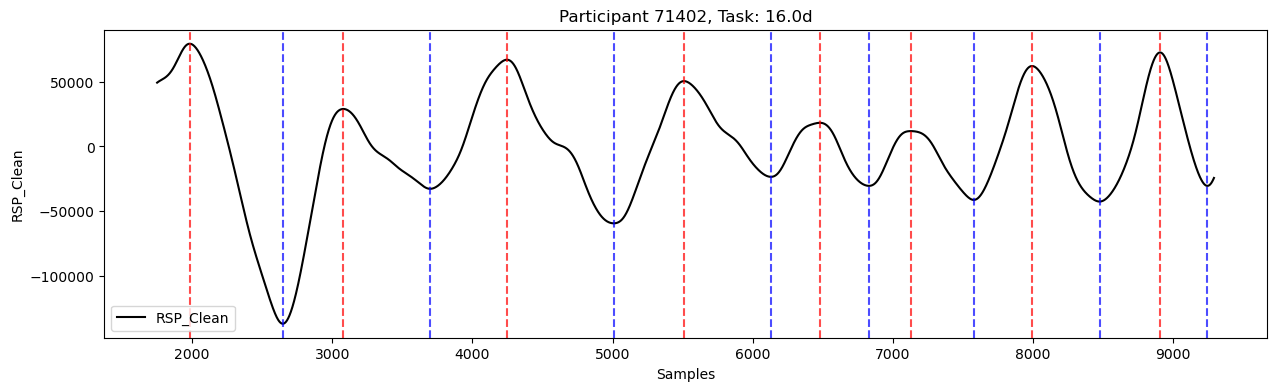

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


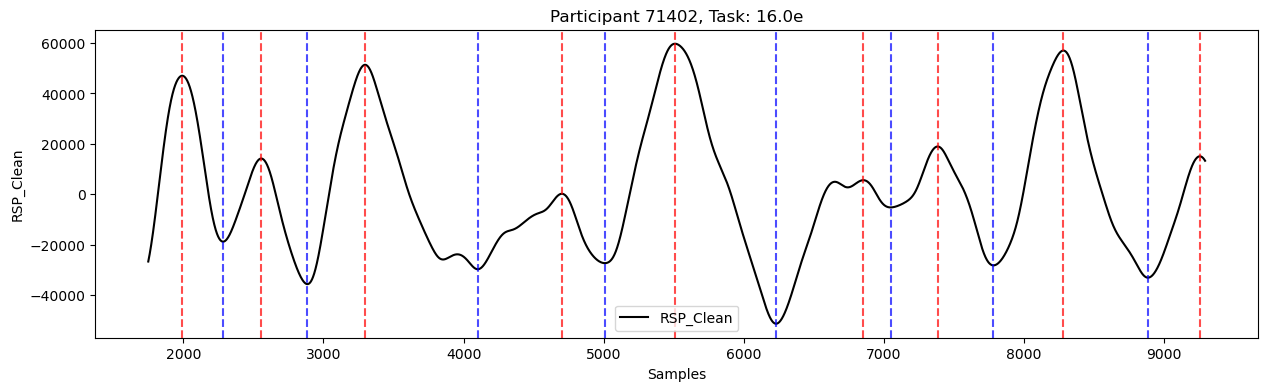

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


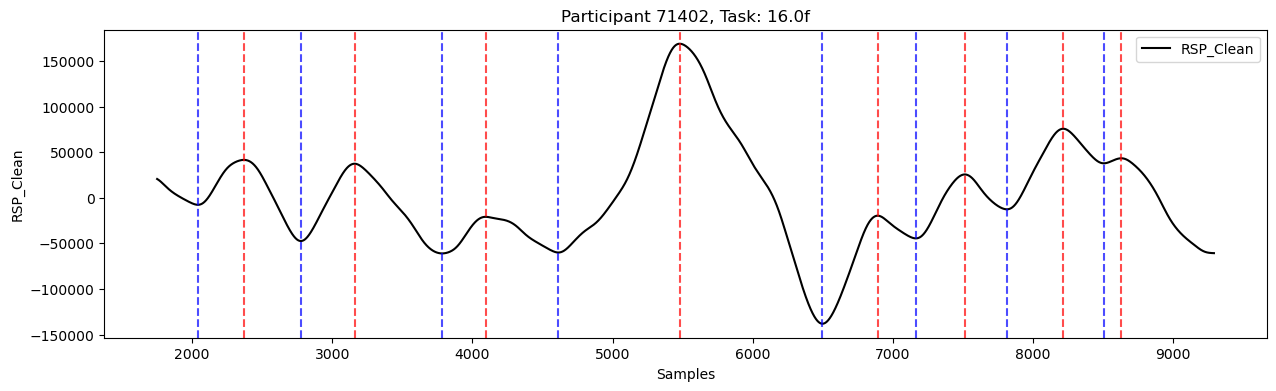

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


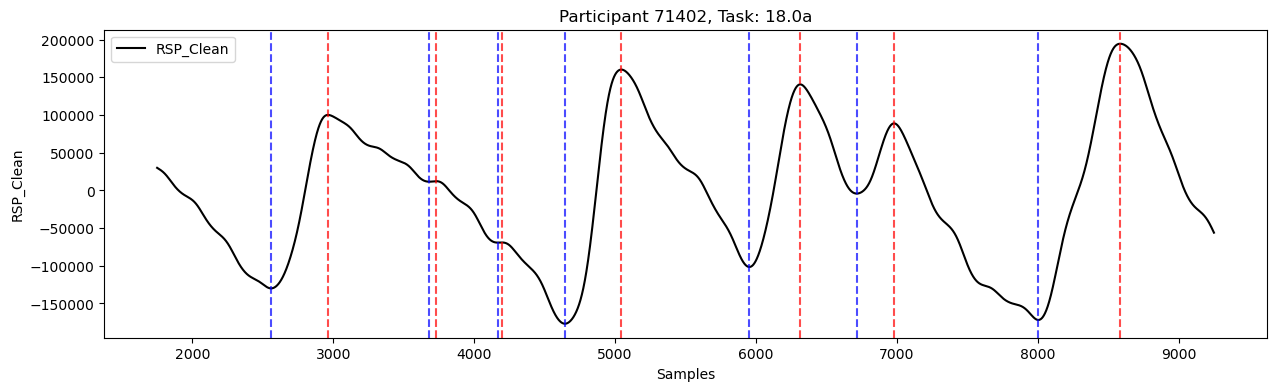

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


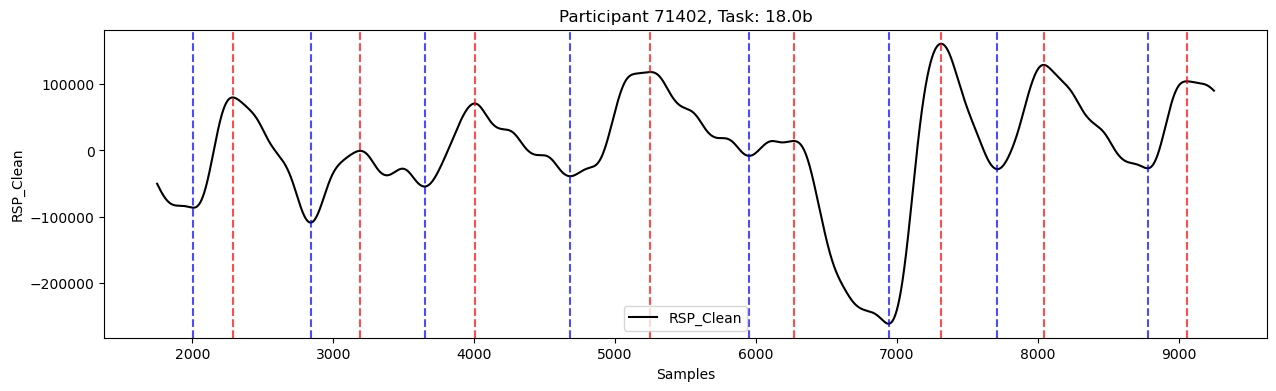

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


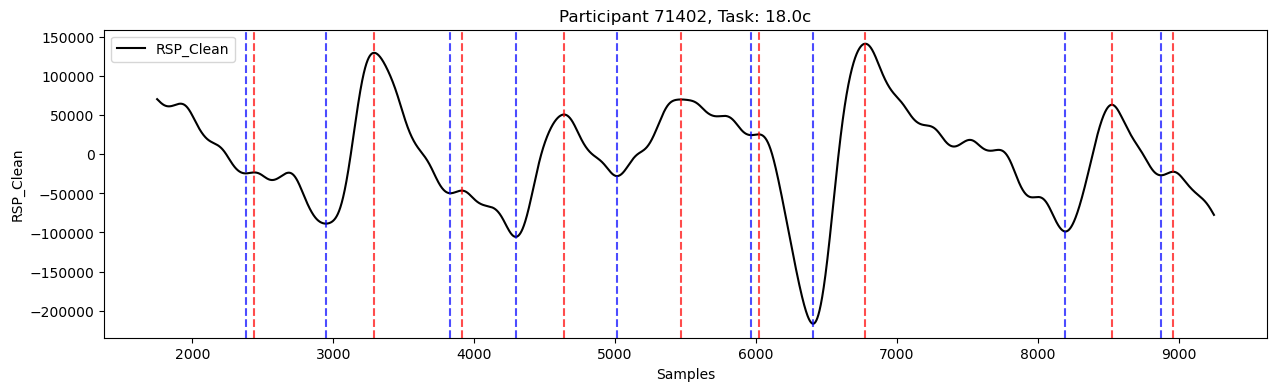

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


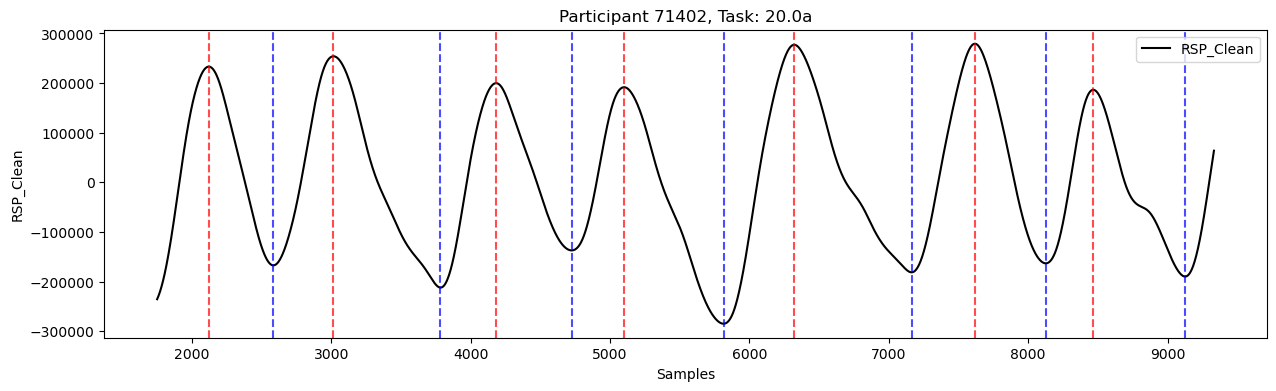

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


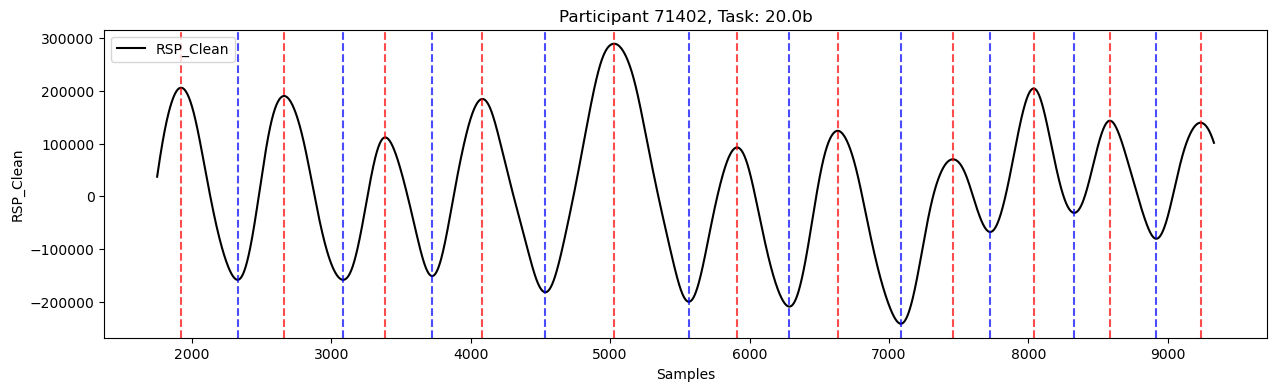

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


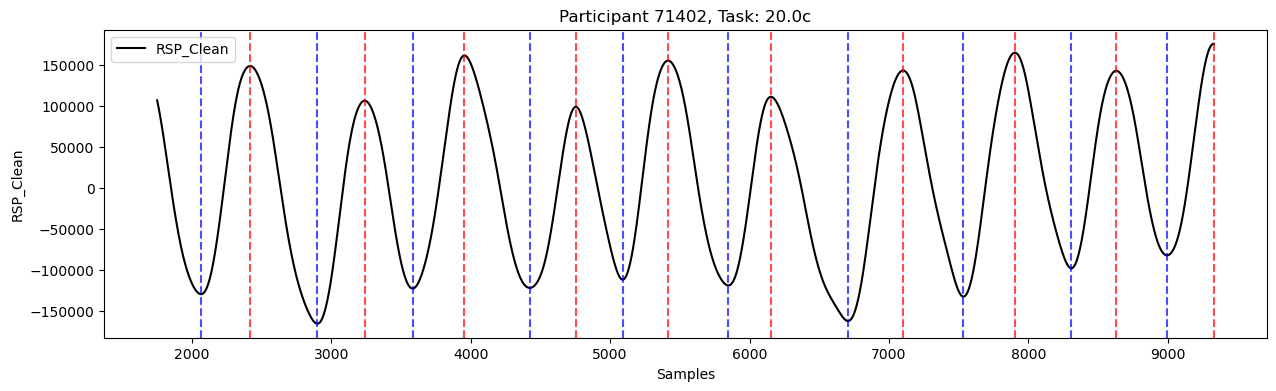

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


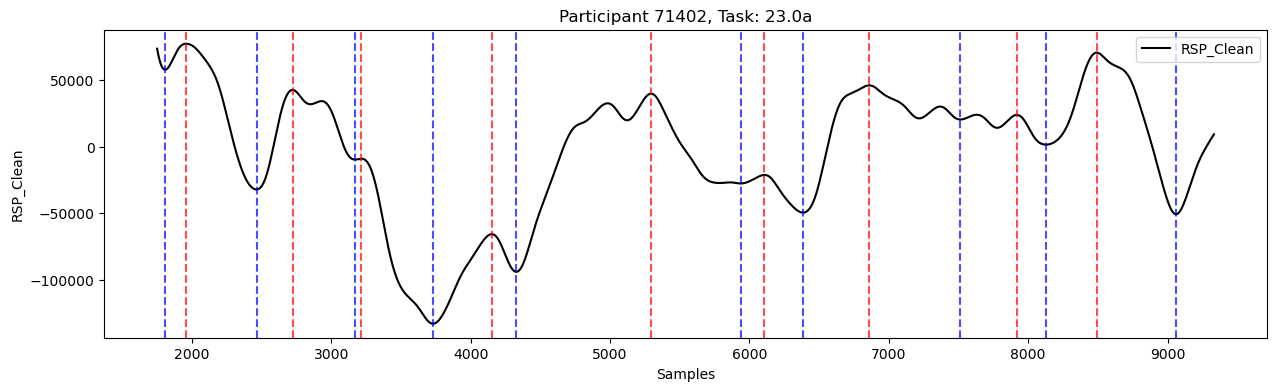

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


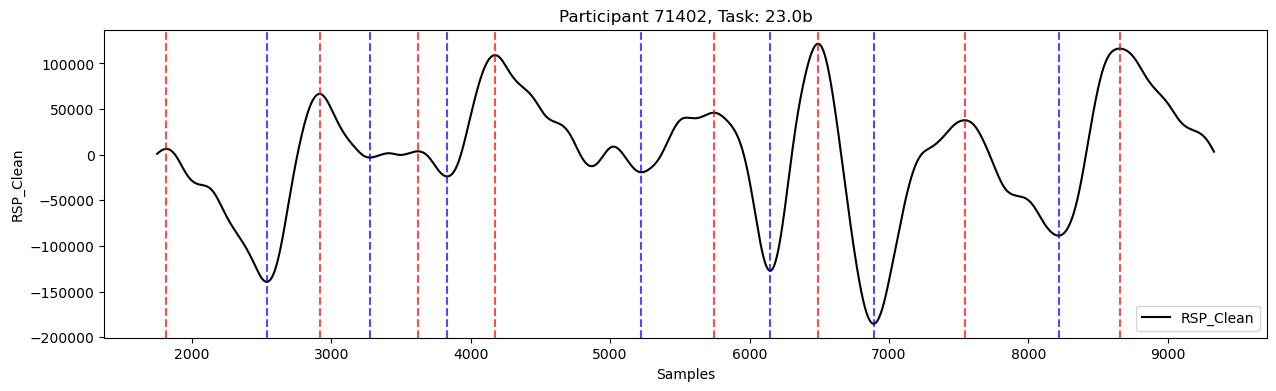

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


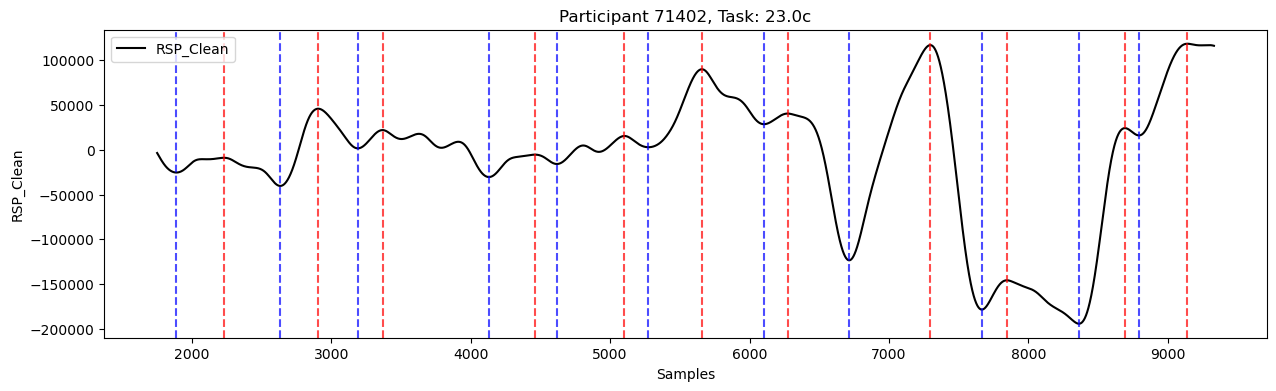

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


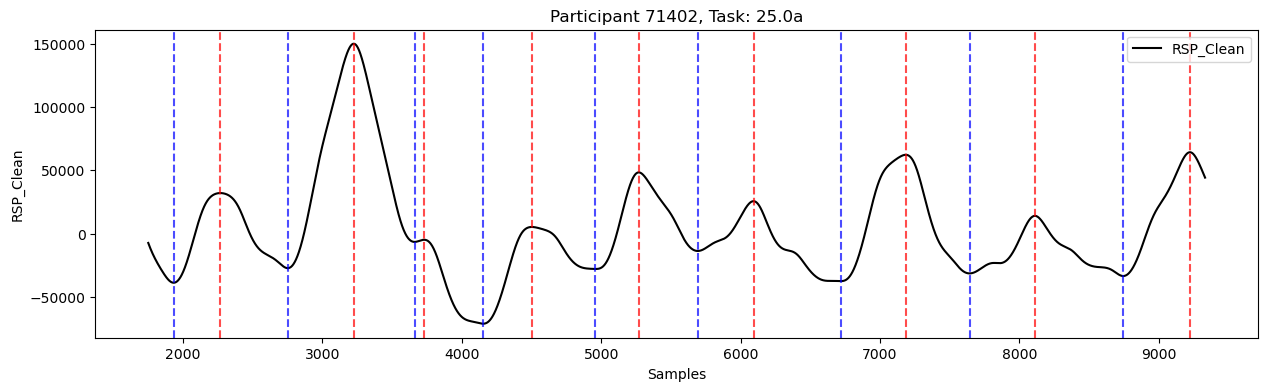

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


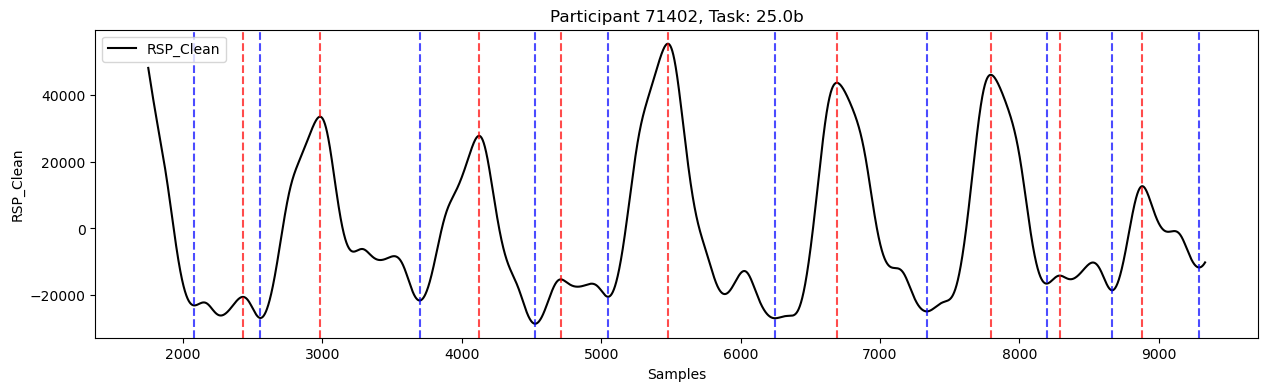

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


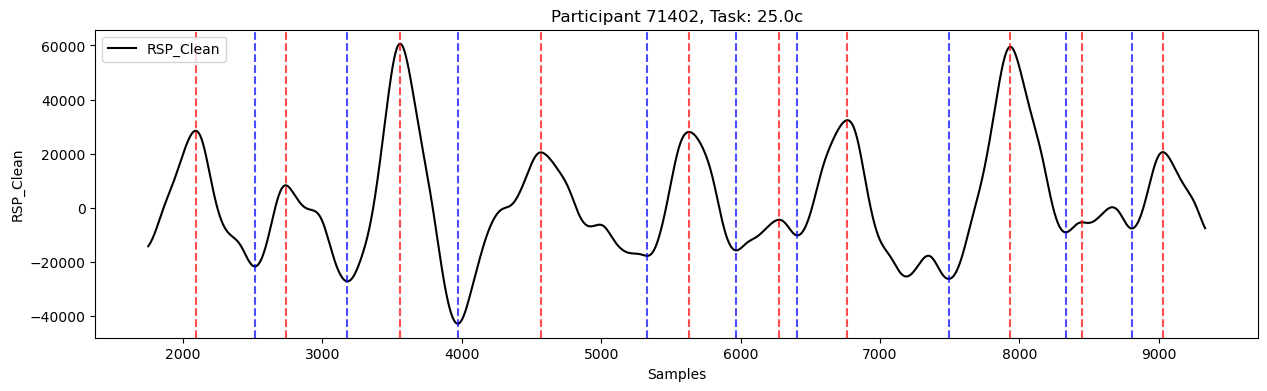

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


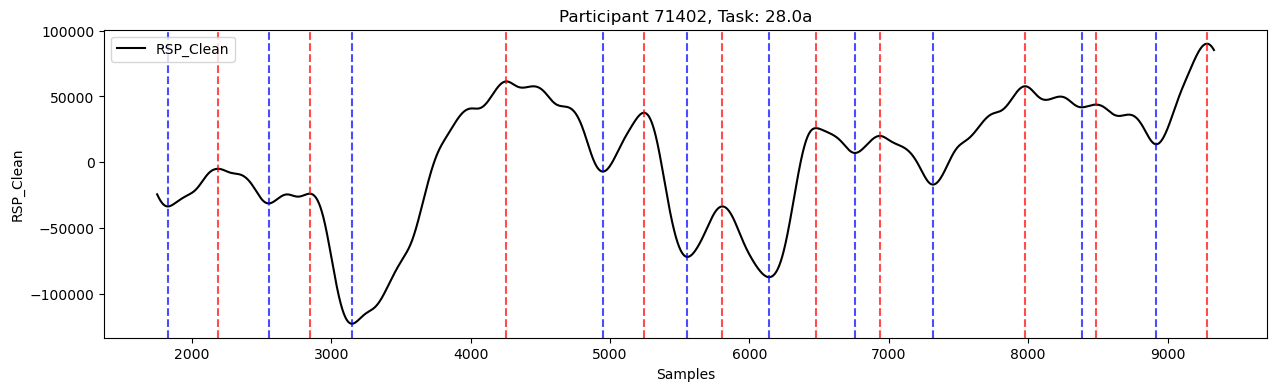

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


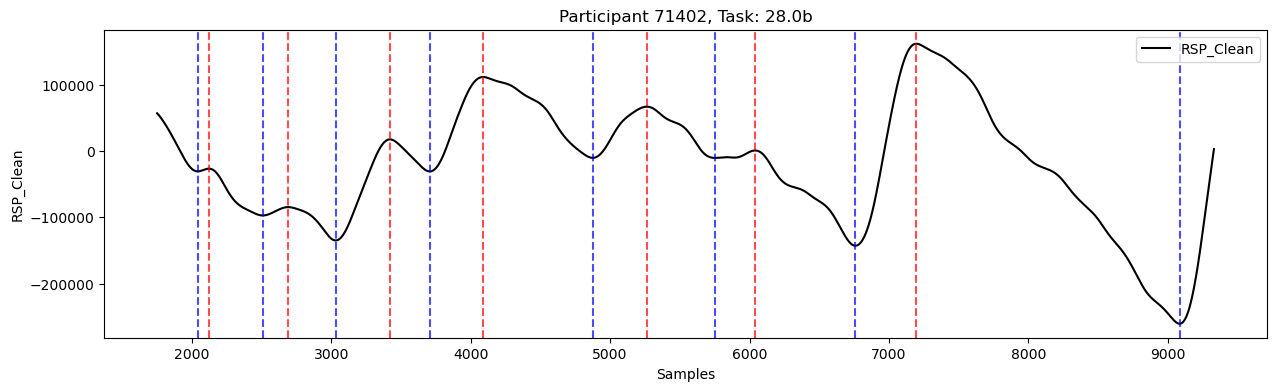

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


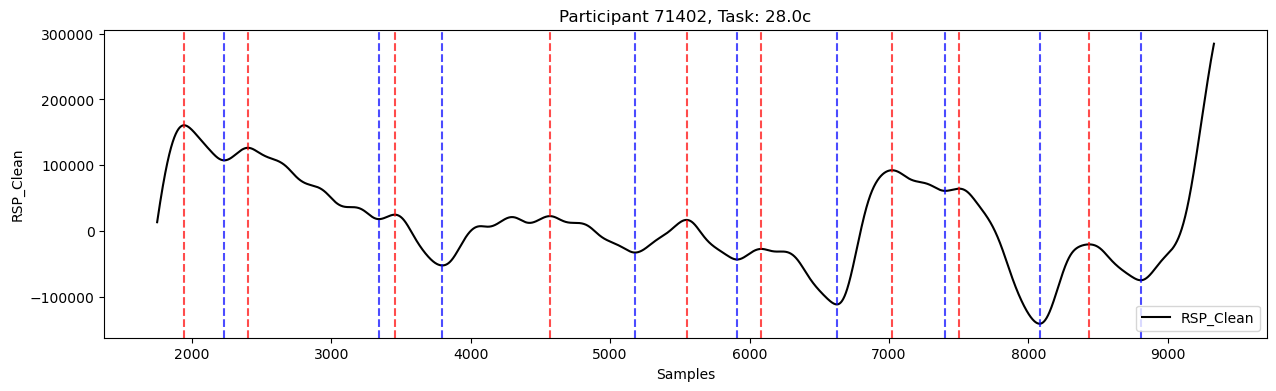

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


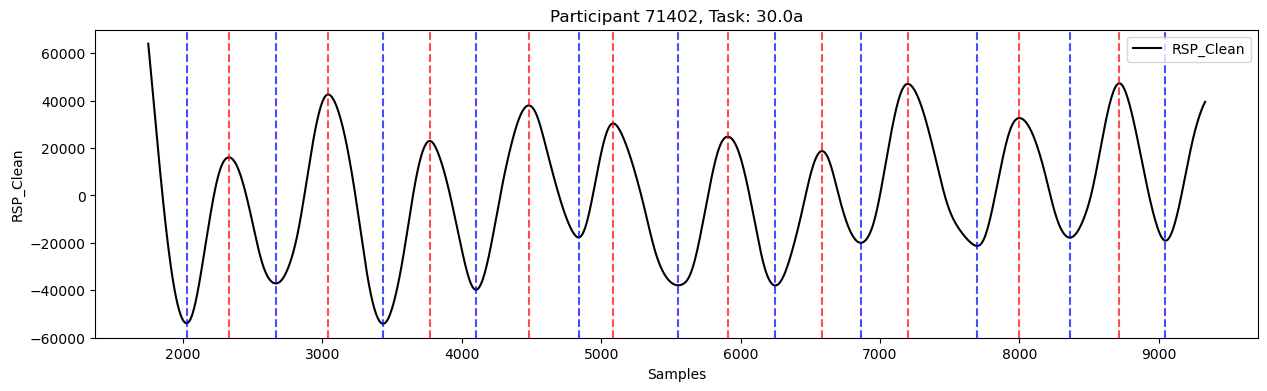

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


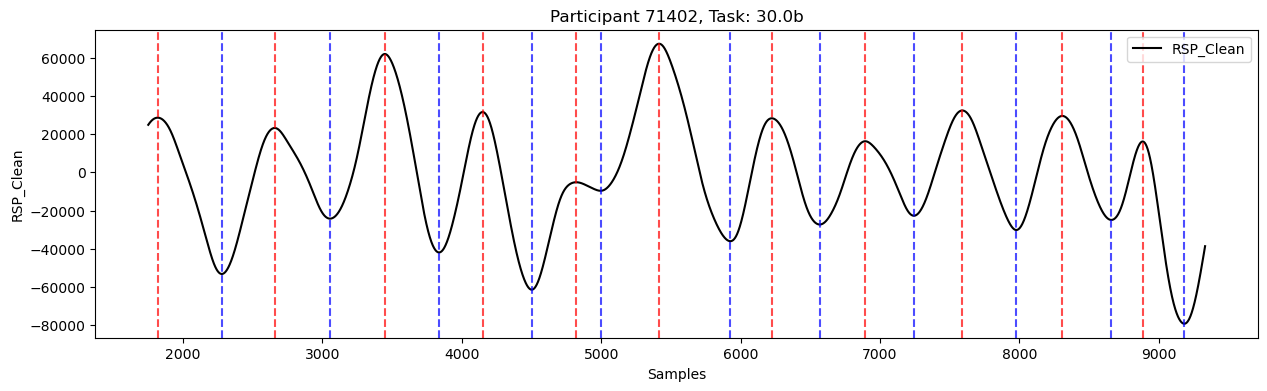

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


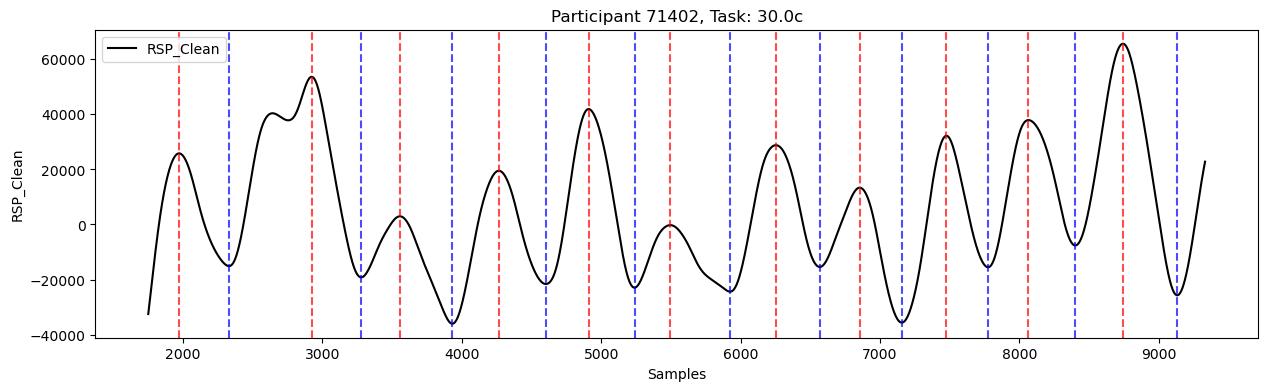

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


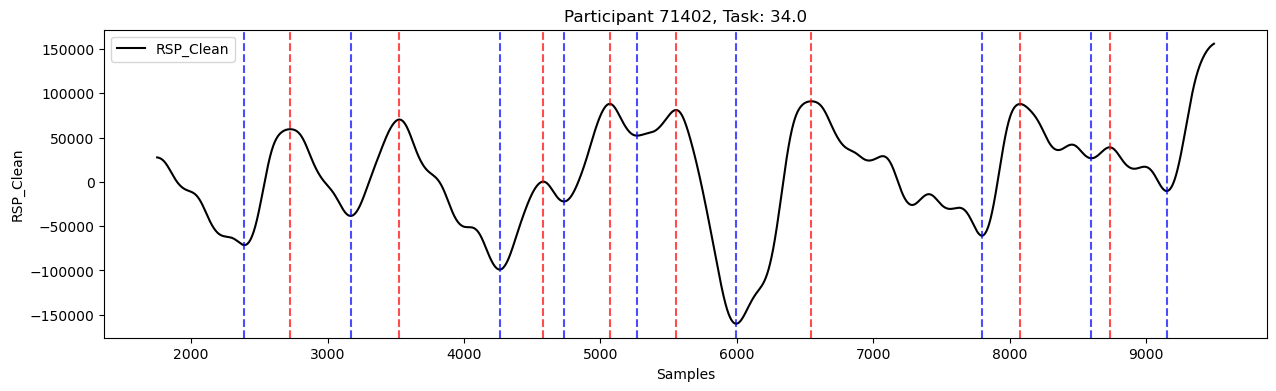

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


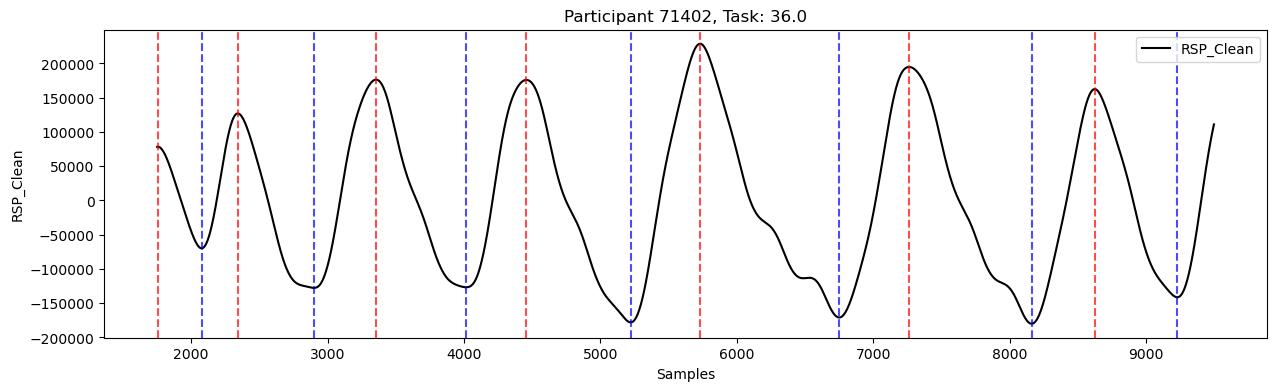

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


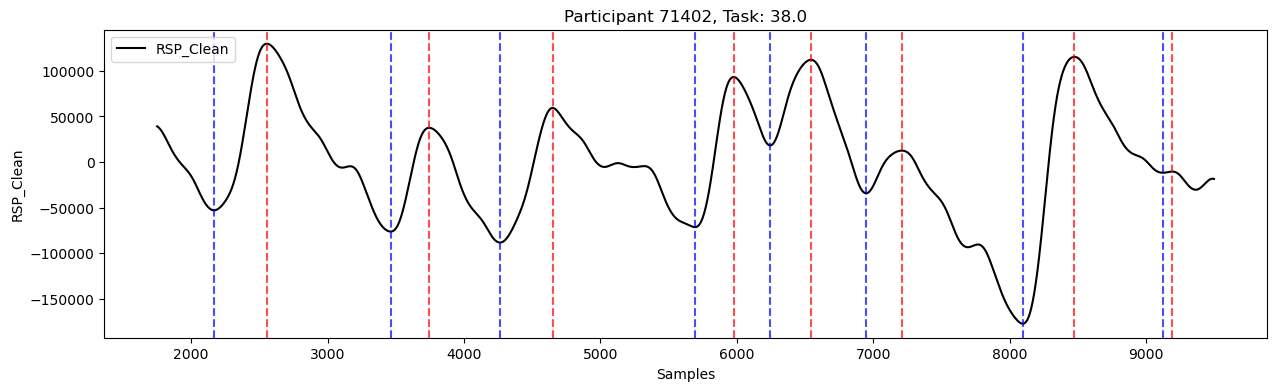

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


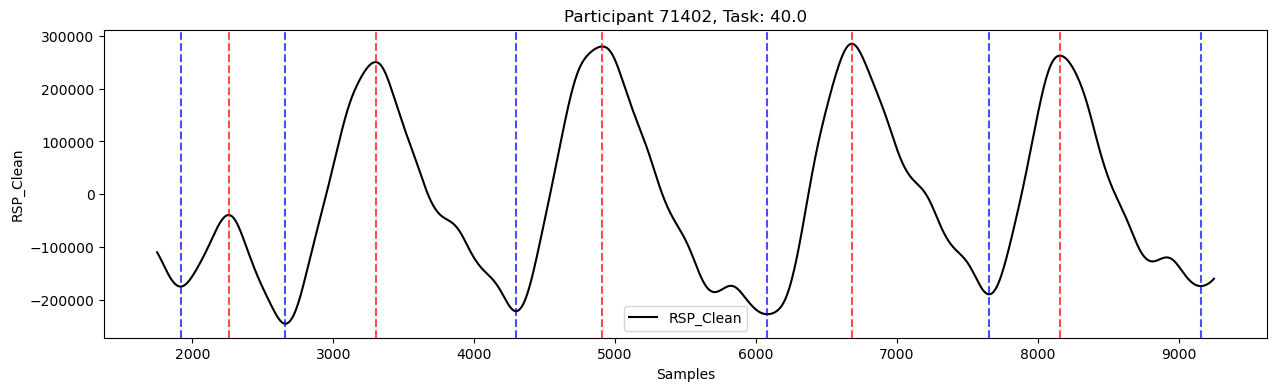

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


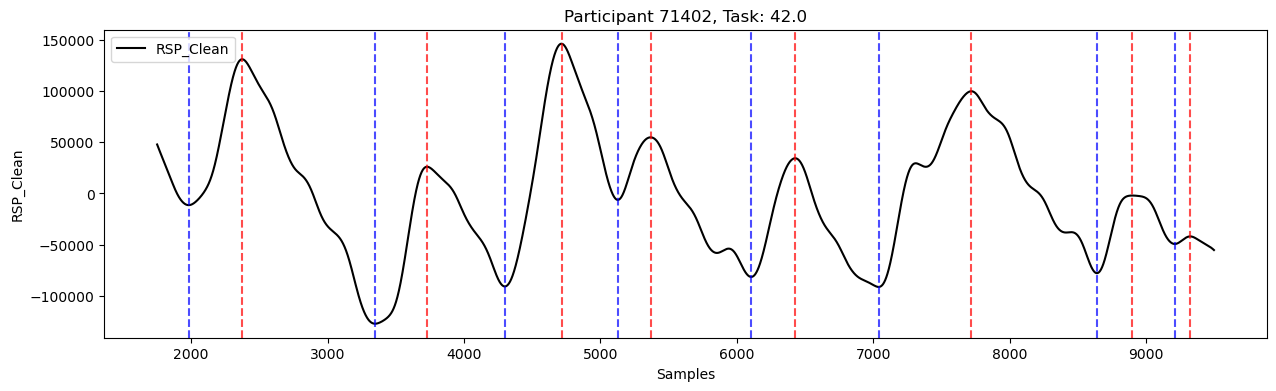

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


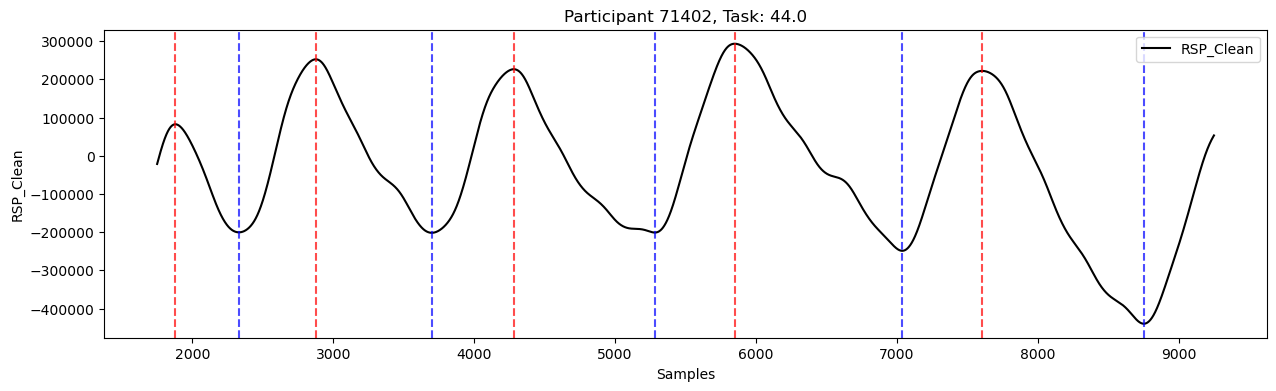

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


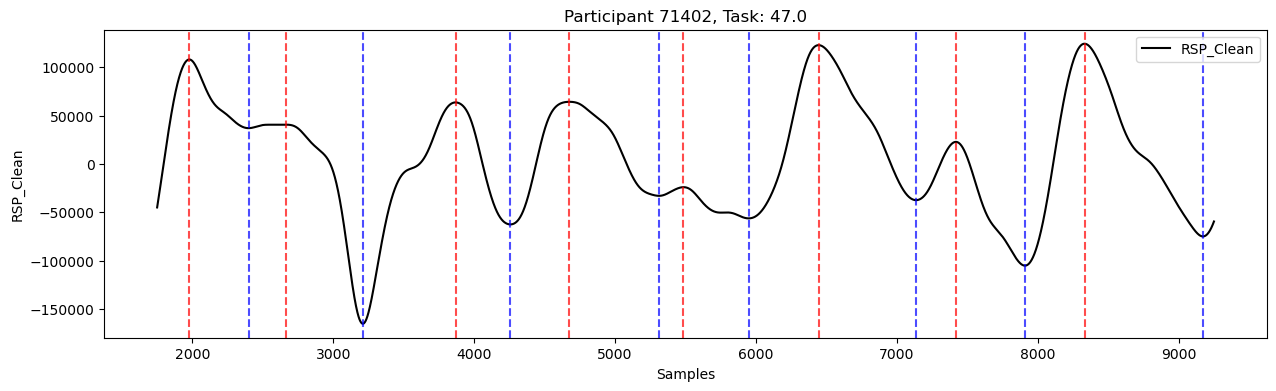

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


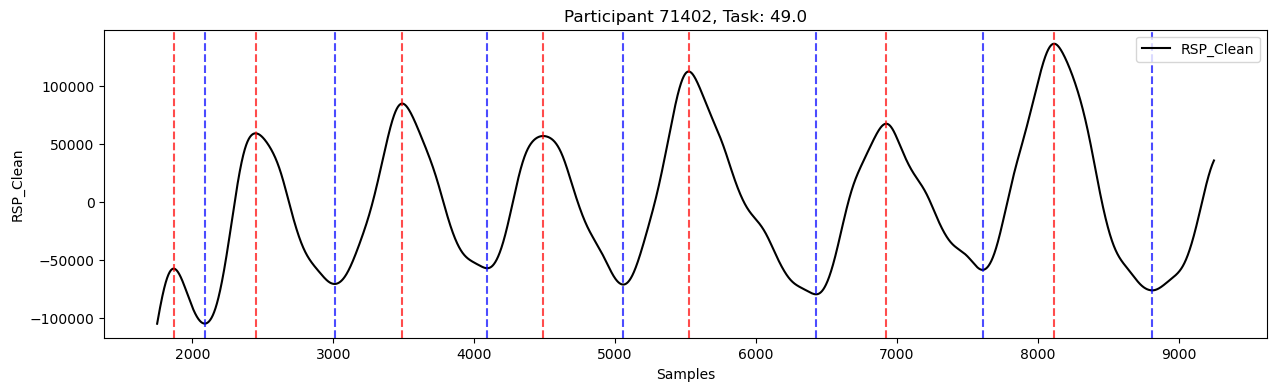

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


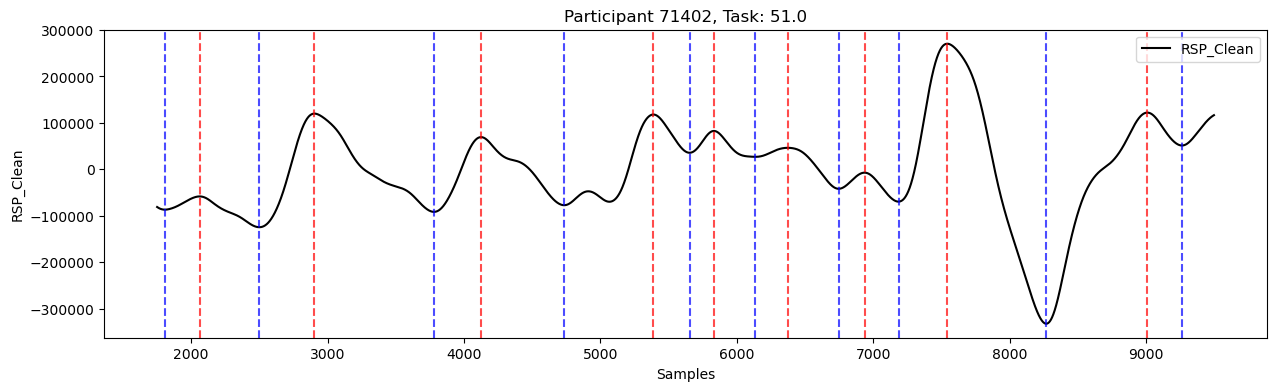

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


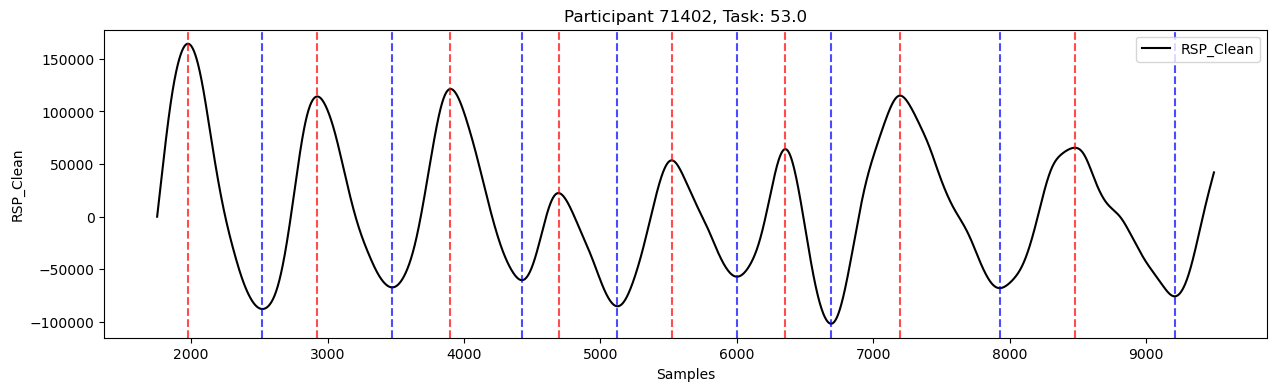

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


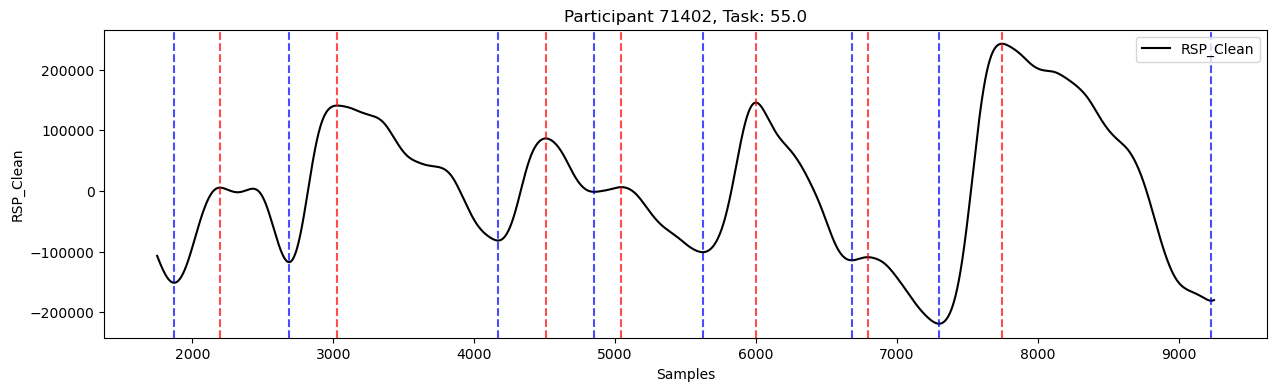

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


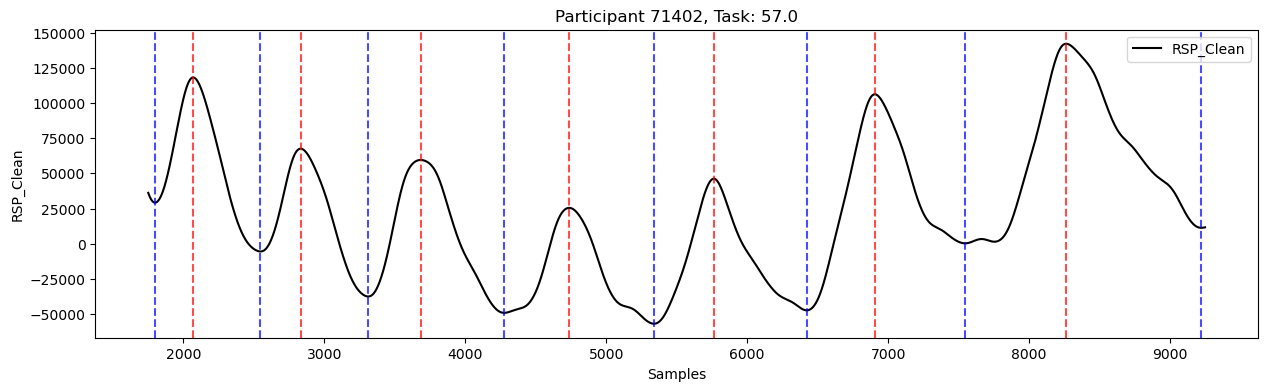

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


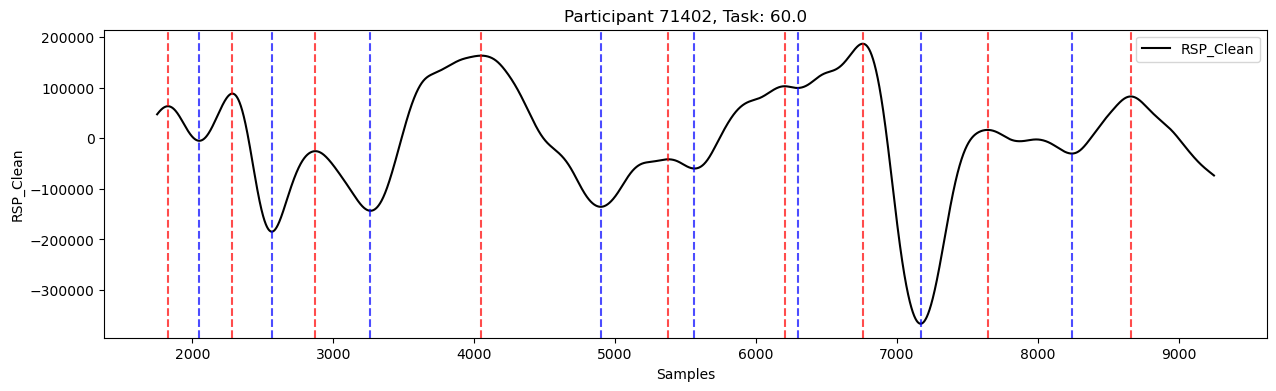

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


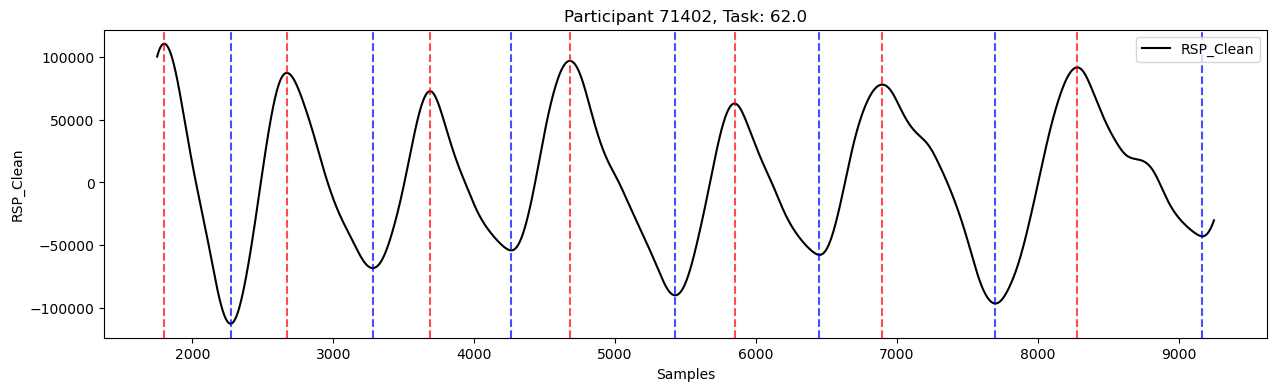

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


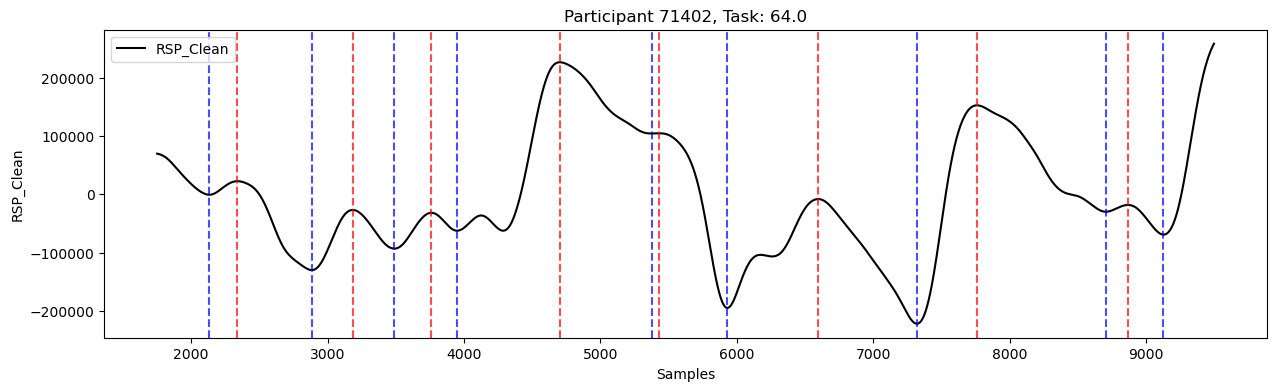

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


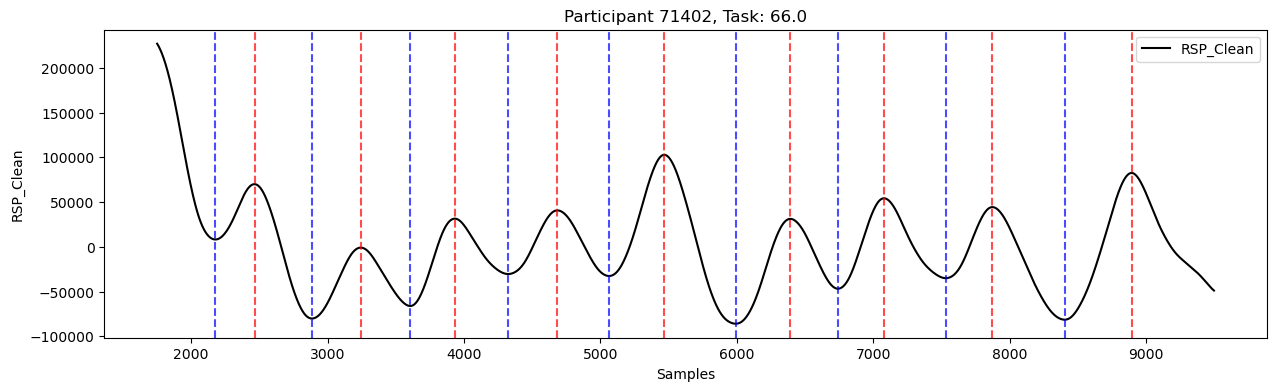

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


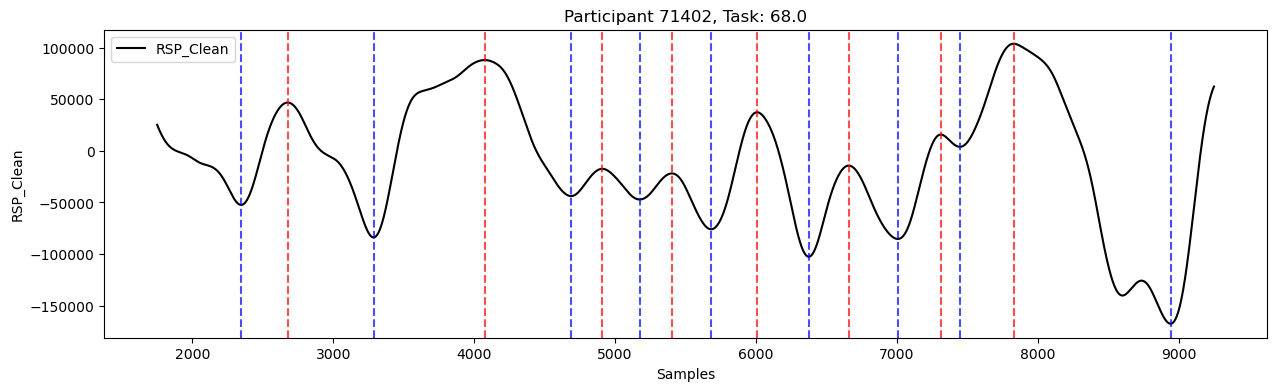

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


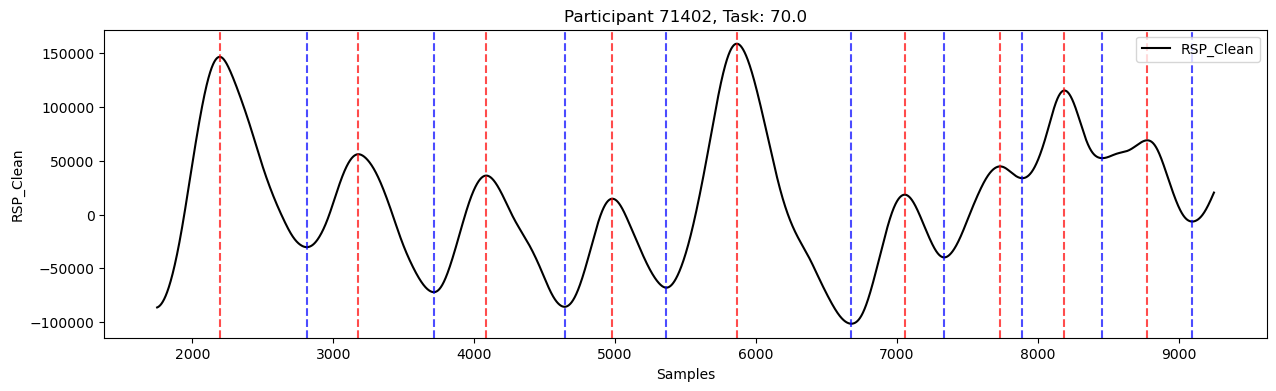

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


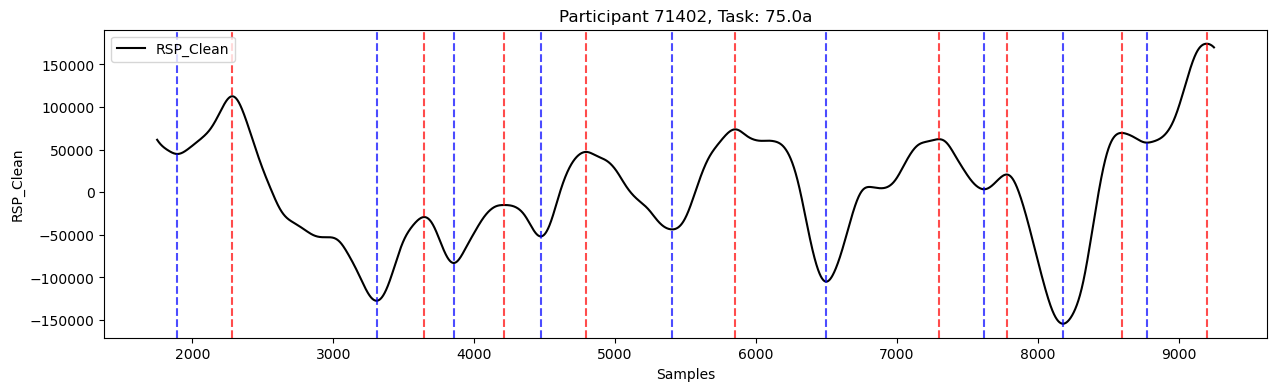

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


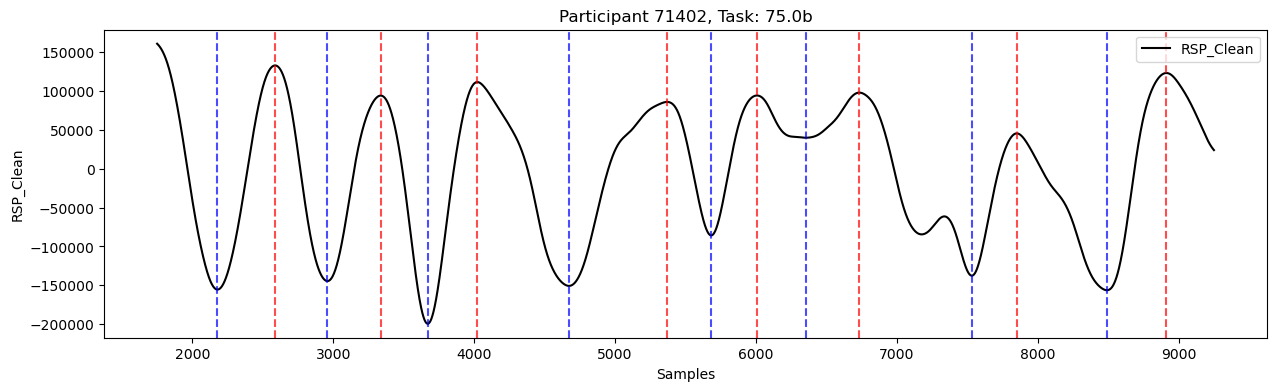

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


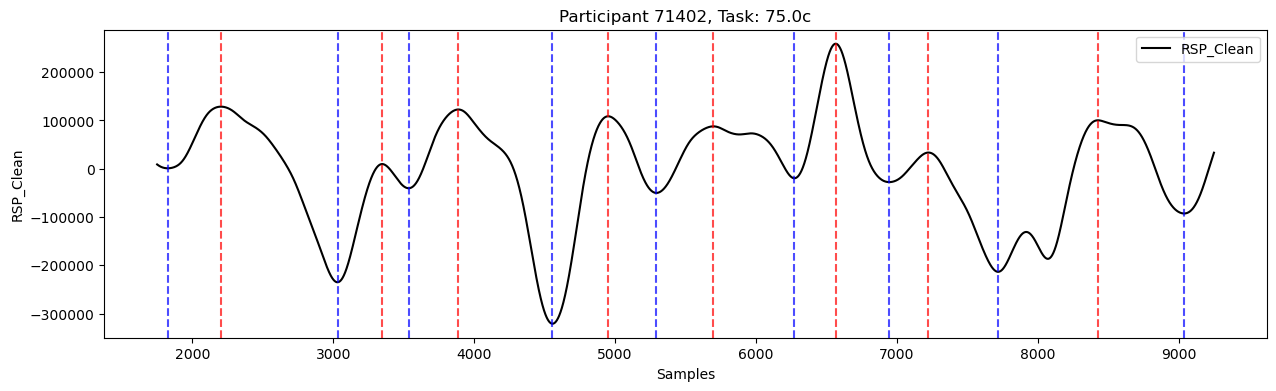

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


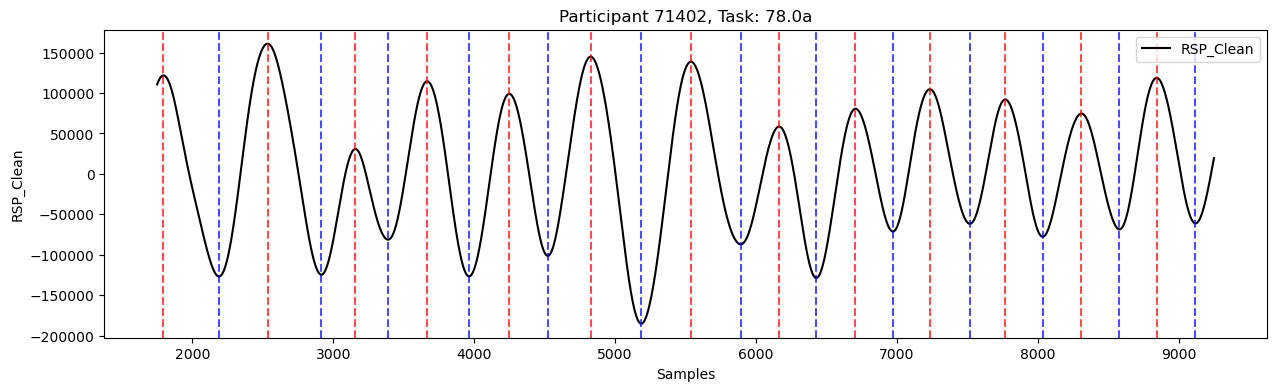

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


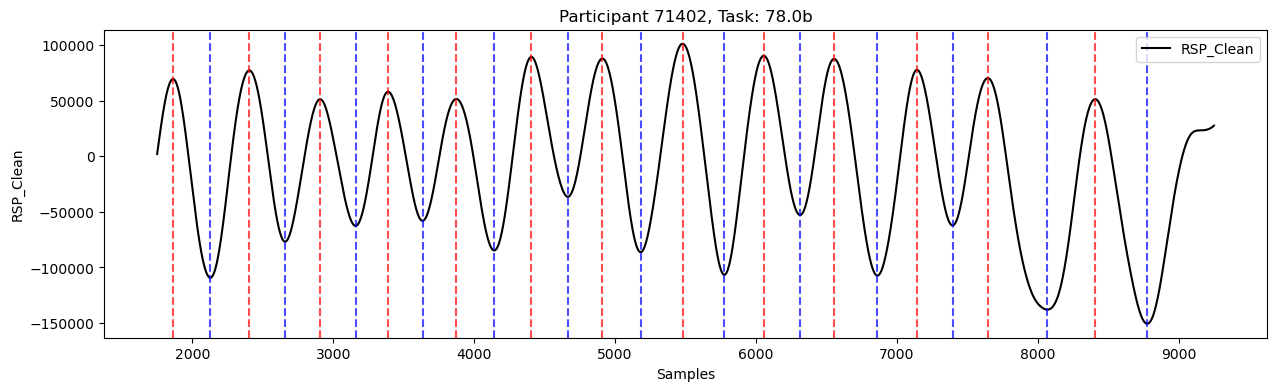

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


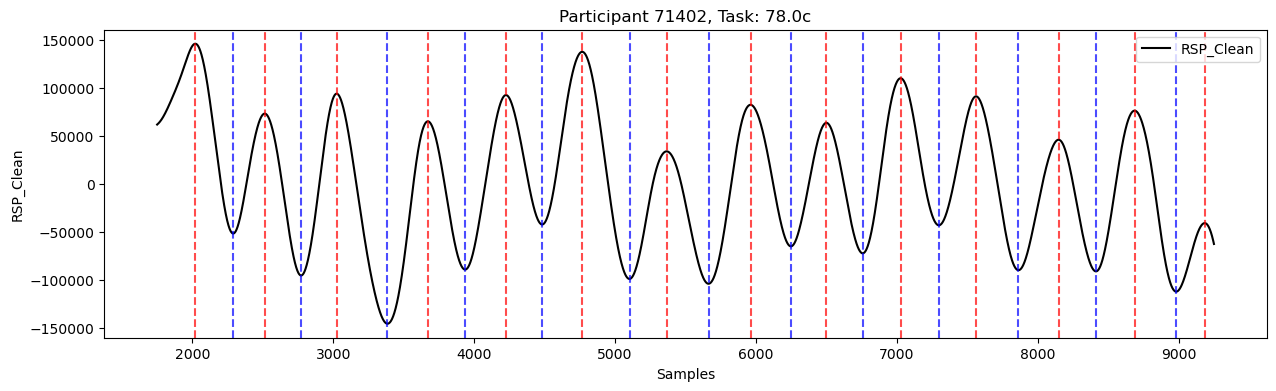

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


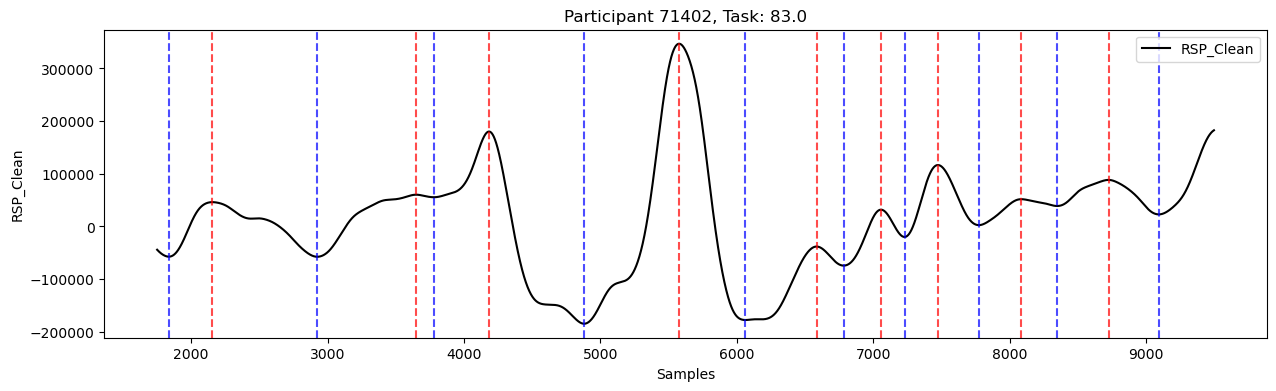

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


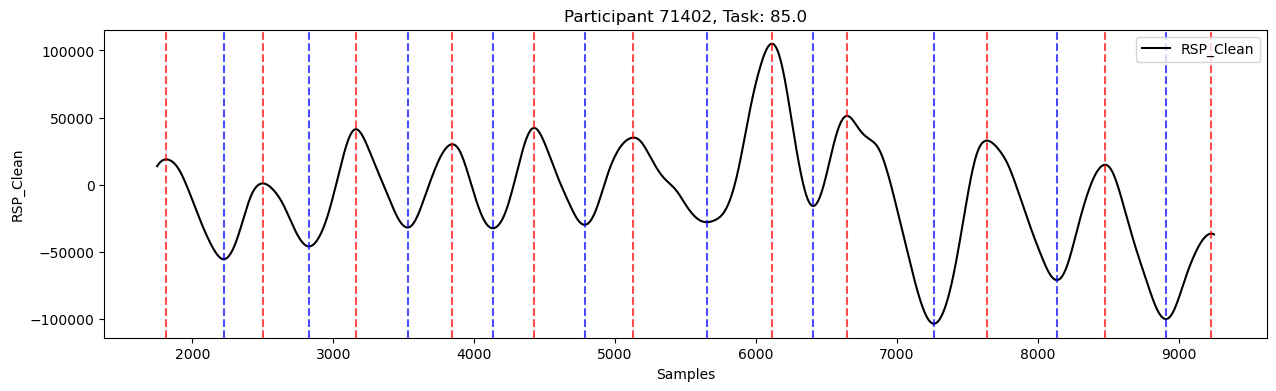

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


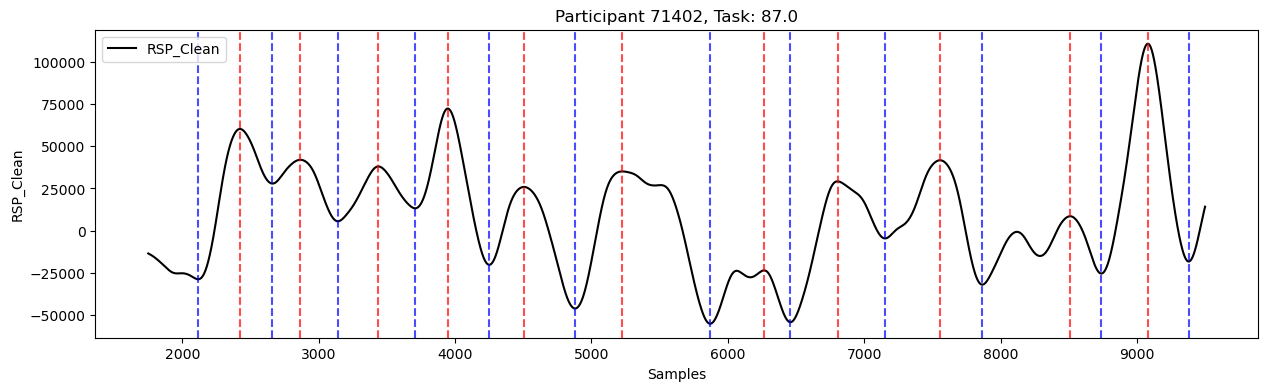

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


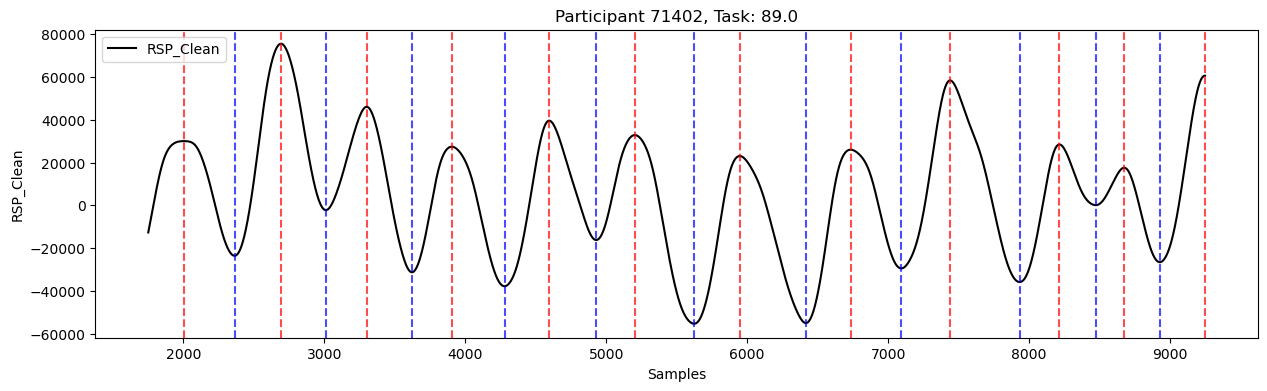

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


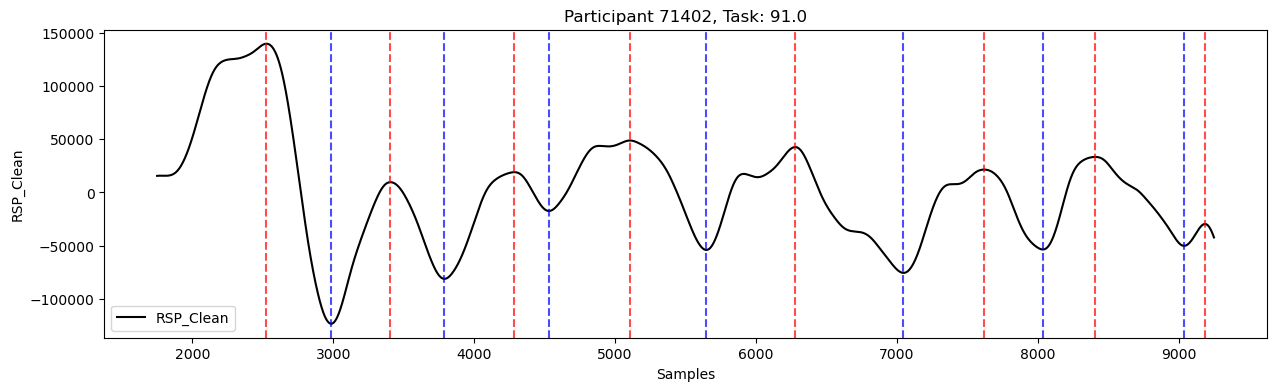

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\1222625541.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = processed_data_with_label.loc[task_start:task_end][processed_data_with_label['RSP_Troughs'] == 1].index


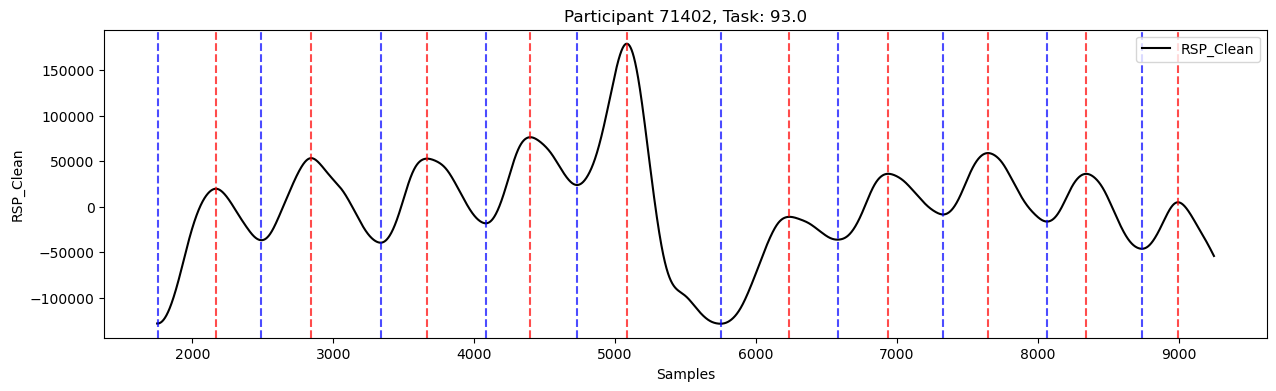

In [4]:
#define the tasks, enter the participant ID to process and to visualize

tasks = ['12.0a', '12.0b', '12.0c', '12.0d', '12.0e', '12.0f', '14.0a', '14.0b', '14.0c', '14.0d', '14.0e',
         '14.0f', '16.0a', '16.0b', '16.0c', '16.0d', '16.0e', '16.0f', '18.0a', '18.0b', '18.0c', '20.0a',
         '20.0b', '20.0c', '23.0a', '23.0b', '23.0c', '25.0a', '25.0b', '25.0c', '28.0a', '28.0b', '28.0c',
         '30.0a', '30.0b', '30.0c', 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 60.0,
         62.0, 64.0, 66.0, 68.0, 70.0, '75.0a', '75.0b', '75.0c', '78.0a', '78.0b', '78.0c', 83.0, 85.0, 87.0,
         89.0, 91.0, 93.0]

participant_ids = [71402]  # enter your participant ID here

all_processed_data_impedance = {}
for participant_id in participant_ids:
    processed_dataframes_impedance = process_and_visualize_impedance(df_impedance, participant_id, tasks)
    all_processed_data_impedance[participant_id] = processed_dataframes_impedance

#this participant (who provided consent) is one who had a relatively bad quality of their impedance signal 
#(the signal quality of impedance was much better in general)

In [5]:
#to print peaks and troughs, enter the participant ID 
participant_id = 71402 
processed_dataframes = all_processed_data_impedance[participant_id]

for task, df in processed_dataframes.items():
    print(f"Task: {task}")

    # Identify the actual task portion in the dataframe
    task_specific_indices = df.index[df['Task_Label_2'] == task]
    if not task_specific_indices.empty:
        task_start = task_specific_indices[0]
        task_end = task_specific_indices[-1]

        # Extract the indices of peaks and troughs within the task-specific part
        peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
        troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index

        # Print identified peaks and troughs
        print(f"Peaks for task {task}: {peaks.tolist()}")
        print(f"Number of Peaks: {len(peaks)}")
        print(f"Troughs for task {task}: {troughs.tolist()}")
        print(f"Number of Troughs: {len(troughs)}")
        print("\n")


Task: 12.0a
Peaks for task 12.0a: [2945, 4225, 5377, 6700, 7853, 8820]
Number of Peaks: 6
Troughs for task 12.0a: [2449, 3724, 4891, 6187, 7390, 8432, 9192]
Number of Troughs: 7


Task: 12.0b
Peaks for task 12.0b: [2045, 3111, 4316, 5416, 6630, 8046, 9245]
Number of Peaks: 7
Troughs for task 12.0b: [2648, 3776, 4985, 6086, 7542, 8720]
Number of Troughs: 6


Task: 12.0c
Peaks for task 12.0c: [3242, 4681, 5771, 6808, 8242]
Number of Peaks: 5
Troughs for task 12.0c: [2653, 4120, 5423, 6208, 7735, 8984]
Number of Troughs: 6


Task: 12.0d
Peaks for task 12.0d: [2003, 3608, 5004, 6383, 7894]
Number of Peaks: 5
Troughs for task 12.0d: [3032, 4405, 5789, 7253, 8768]
Number of Troughs: 5


Task: 12.0e
Peaks for task 12.0e: [1869, 3450, 4923, 6029, 6989, 8104, 8983]
Number of Peaks: 7
Troughs for task 12.0e: [2810, 4361, 5680, 6491, 7799, 8498]
Number of Troughs: 6


Task: 12.0f
Peaks for task 12.0f: [2660, 4097, 5365, 6446, 7494, 8837]
Number of Peaks: 6
Troughs for task 12.0f: [2231, 3480, 492

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\2787672280.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\2787672280.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index


In [6]:
#this code extracts features that don't come from neurokit (all features except respiratory rate, RRV, and peak-trough symmery)
import numpy as np #now with the corrected exp diff and duty cycle calculations
import pandas as pd

participant_id = 71402  # Enter the participant ID here
processed_dataframes = all_processed_data_impedance[participant_id]
sampling_rate = 250  # Adjusted to 250 Hz for 5fs device, change if your sampling rate is different
task_results = {}
bbb_results = {}

for task, df in processed_dataframes.items():
    print(f"Task: {task}")

    # identifying the actual task portion in the dataframe
    task_specific_indices = df.index[df['Task_Label_2'] == task]
    if not task_specific_indices.empty:
        task_start = task_specific_indices[0]
        task_end = task_specific_indices[-1]

        # extracting the indices of peaks and troughs within the task-specific part
        peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
        troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index

        # combining peaks and troughs into one list and sorting them
        combined_data = [('Peak', index) for index in peaks] + [('Trough', index) for index in troughs]
        combined_data.sort(key=lambda x: x[1])

        # initialize lists to store the respiratory features
        inspiratory_durations = []
        expiratory_durations = []
        inspiratory_amplitudes = []
        expiratory_amplitudes = []
        inspiratory_flows = []
        expiratory_flows = []
        ie_ratios = []
        duty_cycles = []  # Reinitialize to collect correctly
        exp_diffs = []

        # iterate through combined data
        for i in range(1, len(combined_data)):
            current_type, current_index = combined_data[i]
            prev_type, prev_index = combined_data[i-1]

            # duration and amplitude calculation
            duration = (current_index - prev_index) / sampling_rate
            amplitude = abs(df.loc[current_index, 'RSP_Clean'] - df.loc[prev_index, 'RSP_Clean'])

            if current_type == 'Peak' and prev_type == 'Trough':
                inspiratory_durations.append(duration)
                inspiratory_amplitudes.append(amplitude)
                if duration > 0:
                    inspiratory_flows.append(amplitude / duration)
            elif current_type == 'Trough' and prev_type == 'Peak':
                expiratory_durations.append(duration)
                expiratory_amplitudes.append(amplitude)
                if duration > 0:
                    expiratory_flows.append(amplitude / duration)
                if inspiratory_durations:
                    # IE ratio
                    ie_ratio = inspiratory_durations[-1] / duration
                    ie_ratios.append(ie_ratio)
                    # Duty Cycle for the same breathing cycle
                    total_cycle_duration = inspiratory_durations[-1] + duration
                    duty_cycle = inspiratory_durations[-1] / total_cycle_duration
                    duty_cycles.append(duty_cycle)

        # calculate expiratory differences
        exp_diffs = [abs(expiratory_durations[i] - expiratory_durations[i - 1]) for i in range(1, len(expiratory_durations))]

        # Mean and SD calculations
        insp_dur_mean, insp_dur_sd = np.mean(inspiratory_durations), np.std(inspiratory_durations)
        exp_dur_mean, exp_dur_sd = np.mean(expiratory_durations), np.std(expiratory_durations)
        insp_amp_mean, insp_amp_sd = np.mean(inspiratory_amplitudes), np.std(inspiratory_amplitudes)
        exp_amp_mean, exp_amp_sd = np.mean(expiratory_amplitudes), np.std(expiratory_amplitudes)
        insp_flow_mean, insp_flow_sd = np.mean(inspiratory_flows), np.std(inspiratory_flows)
        exp_flow_mean, exp_flow_sd = np.mean(expiratory_flows), np.std(expiratory_flows)
        ie_ratio_mean, ie_ratio_sd = np.mean(ie_ratios), np.std(ie_ratios)
        duty_cycle_mean = np.mean(duty_cycles) if duty_cycles else 0
        exp_diff_mean = np.mean(exp_diffs) if exp_diffs else 0

        # storing the results
        task_results[task] = {
            'insp_dur_mean': insp_dur_mean,
            'insp_dur_sd': insp_dur_sd,
            'exp_dur_mean': exp_dur_mean,
            'exp_dur_sd': exp_dur_sd,
            'insp_amp_mean': insp_amp_mean,
            'insp_amp_sd': insp_amp_sd,
            'exp_amp_mean': exp_amp_mean,
            'exp_amp_sd': exp_amp_sd,
            'insp_flow_mean': insp_flow_mean,
            'insp_flow_sd': insp_flow_sd,
            'exp_flow_mean': exp_flow_mean,
            'exp_flow_sd': exp_flow_sd,
            'ie_ratio_mean': ie_ratio_mean,
            'ie_ratio_sd': ie_ratio_sd,
            'duty_cycle_mean': duty_cycle_mean,
            'exp_diff_mean': exp_diff_mean
        }

        # storing the breath-by-breath results separately
        bbb_results[task] = {
            'inspiratory_durations': inspiratory_durations,
            'expiratory_durations': expiratory_durations,
            'inspiratory_amplitudes': inspiratory_amplitudes,
            'expiratory_amplitudes': expiratory_amplitudes,
            'inspiratory_flows': inspiratory_flows,
            'expiratory_flows': expiratory_flows,
            'ie_ratios': ie_ratios,
            'duty_cycles': duty_cycles,
            'exp_diffs': exp_diffs
        }

# convert the dictionary to a DataFrame for task_results
respiratory_analysis_df = pd.DataFrame.from_dict(task_results, orient='index')
respiratory_analysis_df.reset_index(inplace=True)
respiratory_analysis_df.rename(columns={'index': 'Task_Label'}, inplace=True)

# create a DataFrame for bbb_results (these are breath by breath values such as inspiration time and expiration time)
bbb_dataframe = pd.DataFrame.from_dict(bbb_results, orient='index')
bbb_dataframe.reset_index(inplace=True)
bbb_dataframe.rename(columns={'index': 'Task_Label'}, inplace=True)

# Display the dataframe with the features (main goal)
respiratory_analysis_df


Task: 12.0a
Task: 12.0b
Task: 12.0c
Task: 12.0d
Task: 12.0e
Task: 12.0f
Task: 14.0a
Task: 14.0b
Task: 14.0c
Task: 14.0d
Task: 14.0e
Task: 14.0f
Task: 16.0a
Task: 16.0b
Task: 16.0c
Task: 16.0d
Task: 16.0e
Task: 16.0f
Task: 18.0a
Task: 18.0b
Task: 18.0c
Task: 20.0a
Task: 20.0b
Task: 20.0c
Task: 23.0a
Task: 23.0b
Task: 23.0c
Task: 25.0a
Task: 25.0b
Task: 25.0c
Task: 28.0a
Task: 28.0b
Task: 28.0c
Task: 30.0a
Task: 30.0b
Task: 30.0c
Task: 34.0
Task: 36.0
Task: 38.0
Task: 40.0
Task: 42.0
Task: 44.0
Task: 47.0
Task: 49.0
Task: 51.0
Task: 53.0
Task: 55.0
Task: 57.0
Task: 60.0
Task: 62.0
Task: 64.0
Task: 66.0
Task: 68.0
Task: 70.0
Task: 75.0a
Task: 75.0b
Task: 75.0c
Task: 78.0a
Task: 78.0b
Task: 78.0c
Task: 83.0
Task: 85.0
Task: 87.0
Task: 89.0
Task: 91.0
Task: 93.0


C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\3723788297.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\3723788297.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index


Task_Label  insp_dur_mean  insp_dur_sd  exp_dur_mean  exp_dur_sd  \
0       12.0a       1.898000     0.166481      2.597333    0.580619   
1       12.0b       2.004667     0.165721      2.795333    0.393639   
2       12.0c       2.084000     0.369172      2.980800    0.682806   
3       12.0d       2.410000     0.095268      3.484000    0.348005   
4       12.0e       1.892667     0.462396      2.850000    0.844265   
..        ...            ...          ...           ...         ...   
61       85.0       1.324000     0.229078      1.642000    0.404025   
62       87.0       1.374182     0.449534      1.267273    0.460753   
63       89.0       1.194545     0.151399      1.440000    0.293770   
64       91.0       1.836000     0.609393      1.969714    0.635861   
65       93.0       1.386400     0.253502      1.677778    0.400325   

    insp_amp_mean    insp_amp_sd   exp_amp_mean    exp_amp_sd  insp_flow_mean  \
0   422257.666524   66028.708393  413284.724262  65722.250760   221080.654811   
1   473155.782785   42894.506147  434836.969339  55055.095413   236285.751184   
2   478376.939194  104626.756536  453294.870178  76895.146234   228716.375121   
3   519000.876426   17901.893489  509578.496918  33236.484961   215658.224723   
4   404305.526779  111365.726712  409149.597955  96816.131062   211583.565414   
..            ...            ...            ...           ...             ...   
61   83049.431121   27431.093363   88573.168767  31802.927714    61971.838495   
62   60048.683707   33154.689291   59094.708528  32837.498013    46140.694120   
63   68016.175593   22339.521831   65237.425846  18955.648241    55312.907630   
64   85741.586988   32323.103010  109916.271297  66755.838548    47441.195635   
65   94024.472671   34581.485783   89685.718979  79372.294366    66787.011360   

    insp_flow_sd  exp_flow_mean   exp_flow_sd  ie_ratio_mean  ie_ratio_sd  \
0   19086.260076  162575.293136  17017.446054       0.762518     0.143040   
1   14926.193447  156431.058946  15824.815550       0.698193     0.074428   
2   23724.277038  155761.692761  19038.296965       0.710757     0.056139   
3   10941.785359  147235.573465  13313.716228       0.725484     0.028756   
4   15410.865330  147206.641875  14772.846465       0.717853     0.056622   
..           ...            ...           ...            ...          ...   
61  12914.269531   55068.371795  19138.329185       0.873345     0.309884   
62  25696.457205   47097.509571  24231.039692       1.222739     0.642009   
63  14107.863147   45003.924622   9462.080440       0.846264     0.144118   
64  15874.799000   57594.848207  35815.824828       1.158017     0.452214   
65  19033.427648   48020.879827  25734.866825       0.898813     0.274110   

    duty_cycle_mean  exp_diff_mean  
0          0.429104       0.556000  
1          0.410009       0.437600  
2          0.414842       1.116000  
3          0.420291       0.333000  
4          0.417224       0.994400  
..              ...            ...  
61         0.452604       0.516000  
62         0.519543       0.486000  
63         0.455100       0.303200  
64         0.517472       0.866667  
65         0.463106       0.544500  

[66 rows x 17 columns]

In [7]:
#below, we extract the features we can from neurokit (as we need three of them)
import pandas as pd
import neurokit2 as nk

processed_dataframes = all_processed_data_impedance[participant_id]  # Ensure this is the correct dictionary for 5fs

# list to store interval-related features for each task
interval_features_list = []

for task, df in processed_dataframes.items():
    task_specific_indices = df.index[df['Task_Label_2'] == task]
    if not task_specific_indices.empty:
        task_start = task_specific_indices[0]
        task_end = task_specific_indices[-1]

        # Extract the task-specific part of the dataframe
        task_specific_df = df.loc[task_start:task_end]

        # Extract interval-related features using nk.rsp_intervalrelated()
        features_df = nk.rsp_intervalrelated(task_specific_df, sampling_rate=250)

        # Add a column for the task label
        features_df['Task_Label'] = task

        # Append the features DataFrame to the list
        interval_features_list.append(features_df)

# Concatenate all feature DataFrames
interval_features_df = pd.concat(interval_features_list, ignore_index=True)

# Display the DataFrame
interval_features_df


RSP_Rate_Mean    RRV_RMSSD   RRV_MeanBB     RRV_SDBB     RRV_SDSD  \
0       12.853481   675.038369  4495.333333   799.389434   597.842789   
1       13.187050   941.347970  4857.600000   565.859346  1085.440617   
2       11.745701  1921.528558  5064.800000  1168.829842  2204.464561   
3       10.449588   220.568961  5736.000000   270.130832   138.583308   
4       12.907463  1928.499935  4550.400000  1458.600974  1997.734717   
..            ...          ...          ...          ...          ...   
61      20.027440   440.395277  2971.555556   432.853067   462.158909   
62      21.978632   803.794999  2641.454545   610.988112   846.306905   
63      22.654139   520.548429  2626.400000   443.177216   544.577308   
64      14.510355  1121.624536  4034.666667   943.290129  1241.446253   
65      19.563073   654.553283  3104.444444   442.196538   698.910172   

    RRV_CVBB  RRV_CVSD  RRV_MedianBB  RRV_MadBB  RRV_MCVBB  ...  \
0   0.177827  0.150164        4740.0   596.0052   0.125739  ...   
1   0.116489  0.193789        4712.0   296.5200   0.062929  ...   
2   0.230775  0.379389        5212.0   972.5856   0.186605  ...   
3   0.047094  0.038453        5696.0   269.8332   0.047372  ...   
4   0.320543  0.423809        5232.0  1441.0872   0.275437  ...   
..       ...       ...           ...        ...        ...  ...   
61  0.145665  0.148204        3024.0   616.7616   0.203956  ...   
62  0.231307  0.304300        2516.0   498.1536   0.197994  ...   
63  0.168739  0.198198        2616.0   246.1116   0.094079  ...   
64  0.233796  0.277997        3982.0   928.1076   0.233076  ...   
65  0.142440  0.210844        2988.0   438.8496   0.146871  ...   

           RAV_SD      RAV_RMSSD  RAV_CVSD       RSP_RVT  \
0    72330.826060   83945.149997  0.198801  86684.619283   
1    90898.184624  112254.246334  0.253473  89657.438932   
2   116976.269940  149225.720628  0.311942  88977.148385   
3    19368.328437   31554.399929  0.061188  83358.843421   
4   113857.241564  175951.446479  0.425766  83504.932834   
..            ...            ...       ...           ...   
61   42362.711352   60415.870356  0.651153  25608.934803   
62   34772.931487   48785.517351  0.812433  14732.716067   
63   22779.041173   33832.238748  0.488188  20177.007931   
64   37716.016313   33223.263703  0.358733  22916.227704   
65   36452.086649   34533.510397  0.367282  18679.899805   

    RSP_Symmetry_PeakTrough  RSP_Symmetry_RiseDecay  \
0                  0.526865                0.417409   
1                  0.513315                0.405399   
2                  0.534744                0.406926   
3                  0.529689                0.405413   
4                  0.532434                0.412920   
..                      ...                     ...   
61                 0.491735                0.452570   
62                 0.446465                0.526143   
63                 0.495299                0.464346   
64                 0.430923                0.526111   
65                 0.510417                0.456934   

    RSP_Phase_Duration_Inspiration  RSP_Phase_Duration_Expiration  \
0                         1.894000                       2.593333   
1                         2.000667                       2.791333   
2                         2.080000                       2.976800   
3                         2.406000                       3.480000   
4                         1.888667                       2.846000   
..                             ...                            ...   
61                        1.320000                       1.638000   
62                        1.370182                       1.263273   
63                        1.190545                       1.436000   
64                        1.832000                       1.965714   
65                        1.382400                       1.673778   

    RSP_Phase_Duration_Ratio  Task_Label  
0                   0.730334       12.0a  
1                   0.716

In [8]:
#let's add the three features we need from neurokit into the previous dataframe of features

selected_columns = interval_features_df[['Task_Label', 'RSP_Symmetry_PeakTrough', 'RRV_RMSSD', 'RSP_Rate_Mean']]

respiratory_analysis_df_2 = pd.merge(respiratory_analysis_df, selected_columns, on='Task_Label', how='left')

In [9]:
#checking if we have missing values
missing_values = respiratory_analysis_df_2.isnull().sum()

print("Missing values in respiratory_analysis_df_2:")
print(missing_values)

for column in respiratory_analysis_df_2.columns:
    if column != 'Task_Label' and missing_values[column] > 0:
        missing_task_label_values = respiratory_analysis_df_2[respiratory_analysis_df_2[column].isnull()]['Task_Label']
        print(f"Missing values in '{column}' column. Corresponding values in 'Task_Label' column:")
        print(missing_task_label_values)

Missing values in respiratory_analysis_df_2:
Task_Label                 0
insp_dur_mean              0
insp_dur_sd                0
exp_dur_mean               0
exp_dur_sd                 0
insp_amp_mean              0
insp_amp_sd                0
exp_amp_mean               0
exp_amp_sd                 0
insp_flow_mean             0
insp_flow_sd               0
exp_flow_mean              0
exp_flow_sd                0
ie_ratio_mean              0
ie_ratio_sd                0
duty_cycle_mean            0
exp_diff_mean              0
RSP_Symmetry_PeakTrough    0
RRV_RMSSD                  0
RSP_Rate_Mean              0
dtype: int64


In [ ]:
#Run this cell if there is a missing value: THIS IMPUTES FOR THE MISSING VALUES OF RR, RMSSD, PEAK TROUGH with the average of
#the individual's all other values for the feature
#If there are no missing values, you may skip this cell

import pandas as pd
from sklearn.impute import SimpleImputer

task_label_column = respiratory_analysis_df_2['Task_Label']

data_for_imputation = respiratory_analysis_df_2.drop(columns=['Task_Label'])

# creating an instance of SimpleImputer with the mean strategy
imputer = SimpleImputer(strategy='mean')

# applying the imputer to the data frame (excluding 'Task_Label' column)
imputed_data = pd.DataFrame(imputer.fit_transform(data_for_imputation), columns=data_for_imputation.columns)

# concatenating the imputed data with the 'Task_Label' column
respiratory_analysis_df_2 = pd.concat([task_label_column, imputed_data], axis=1)

print("DataFrame with imputed values:")
print(respiratory_analysis_df_2)

In [10]:
# We add the inspiratory minute depth (or volume) by multiplying the mean inspiratory depth with the mean respiratory rate
respiratory_analysis_df_2['insp_minu_depth'] = respiratory_analysis_df_2['insp_amp_mean'] * respiratory_analysis_df_2['RSP_Rate_Mean']

#Repeat of expiratory minute depth
respiratory_analysis_df_2['exp_minu_depth'] = respiratory_analysis_df_2['exp_amp_mean'] * respiratory_analysis_df_2['RSP_Rate_Mean']
#if wanted, we can add a new column with the participant number
#respiratory_analysis_df_2['Participant'] = 58682

In [11]:
# Adding 'ImP_' to the beginning of all column names
respiratory_analysis_df_2.columns = 'ImP_' + respiratory_analysis_df_2.columns

# Display the modified DataFrame
respiratory_analysis_df_2


ImP_Task_Label  ImP_insp_dur_mean  ImP_insp_dur_sd  ImP_exp_dur_mean  \
0           12.0a           1.898000         0.166481          2.597333   
1           12.0b           2.004667         0.165721          2.795333   
2           12.0c           2.084000         0.369172          2.980800   
3           12.0d           2.410000         0.095268          3.484000   
4           12.0e           1.892667         0.462396          2.850000   
..            ...                ...              ...               ...   
61           85.0           1.324000         0.229078          1.642000   
62           87.0           1.374182         0.449534          1.267273   
63           89.0           1.194545         0.151399          1.440000   
64           91.0           1.836000         0.609393          1.969714   
65           93.0           1.386400         0.253502          1.677778   

    ImP_exp_dur_sd  ImP_insp_amp_mean  ImP_insp_amp_sd  ImP_exp_amp_mean  \
0         0.580619      422257.666524     66028.708393     413284.724262   
1         0.393639      473155.782785     42894.506147     434836.969339   
2         0.682806      478376.939194    104626.756536     453294.870178   
3         0.348005      519000.876426     17901.893489     509578.496918   
4         0.844265      404305.526779    111365.726712     409149.597955   
..             ...                ...              ...               ...   
61        0.404025       83049.431121     27431.093363      88573.168767   
62        0.460753       60048.683707     33154.689291      59094.708528   
63        0.293770       68016.175593     22339.521831      65237.425846   
64        0.635861       85741.586988     32323.103010     109916.271297   
65        0.400325       94024.472671     34581.485783      89685.718979   

    ImP_exp_amp_sd  ImP_insp_flow_mean  ...  ImP_exp_flow_sd  \
0     65722.250760       221080.654811  ...     17017.446054   
1     55055.095413       236285.751184  ...     15824.815550   
2     76895.146234       228716.375121  ...     19038.296965   
3     33236.484961       215658.224723  ...     13313.716228   
4     96816.131062       211583.565414  ...     14772.846465   
..             ...                 ...  ...              ...   
61    31802.927714        61971.838495  ...     19138.329185   
62    32837.498013        46140.694120  ...     24231.039692   
63    18955.648241        55312.907630  ...      9462.080440   
64    66755.838548        47441.195635  ...     35815.824828   
65    79372.294366        66787.011360  ...     25734.866825   

    ImP_ie_ratio_mean  ImP_ie_ratio_sd  ImP_duty_cycle_mean  \
0            0.762518         0.143040             0.429104   
1            0.698193         0.074428             0.410009   
2            0.710757         0.056139             0.414842   
3            0.725484         0.028756             0.420291   
4            0.717853         0.056622             0.417224   
..                ...              ...                  ...   
61           0.873345         0.309884             0.452604   
62           1.222739         0.642009             0.519543   
63           0.846264         0.144118             0.455100   
64           1.158017         0.452214             0.517472   
65           0.898813         0.274110             0.463106   

    ImP_exp_diff_mean  ImP_RSP_Symmetry_PeakTrough  ImP_RRV_RMSSD  \
0            0.556000                     0.526865     675.038369   
1            0.437600                     0.513315     941.347970   
2            1.116000                     0.534744    1921.528558   
3            0.333000                     0.529689     220.568961   
4            0.994400                     0.532434    1928.499935   
..                ...                          ...            ...   
61           0.516000                     0.491735     440.395277   
62           0.486000                     0.446465     803.794999   
63           0.303200                     

In [12]:
#SKIP THIS STEP IF YOU USED AN IMPEDANCE SIGNAL WHICH YOU DID NOT NEED TO MULTIPLY BY A FACTOR IN THE BEGINNING
#IF YOU WERE ABLE TO DETECT THE PEAKS AND TROUGHS FROM YOUR RAW SIGNAL AS IT IS, SKIP THIS STEP
cols = [
    'ImP_insp_amp_mean', 'ImP_insp_amp_sd', 'ImP_exp_amp_mean', 'ImP_exp_amp_sd',
    'ImP_insp_flow_mean', 'ImP_insp_flow_sd', 'ImP_exp_flow_mean', 'ImP_exp_flow_sd',
    'ImP_insp_minu_depth', 'ImP_exp_minu_depth'
]

respiratory_analysis_df_2[cols] = respiratory_analysis_df_2[cols] / 1000000
respiratory_analysis_df_2

ImP_Task_Label  ImP_insp_dur_mean  ImP_insp_dur_sd  ImP_exp_dur_mean  \
0           12.0a           1.898000         0.166481          2.597333   
1           12.0b           2.004667         0.165721          2.795333   
2           12.0c           2.084000         0.369172          2.980800   
3           12.0d           2.410000         0.095268          3.484000   
4           12.0e           1.892667         0.462396          2.850000   
..            ...                ...              ...               ...   
61           85.0           1.324000         0.229078          1.642000   
62           87.0           1.374182         0.449534          1.267273   
63           89.0           1.194545         0.151399          1.440000   
64           91.0           1.836000         0.609393          1.969714   
65           93.0           1.386400         0.253502          1.677778   

    ImP_exp_dur_sd  ImP_insp_amp_mean  ImP_insp_amp_sd  ImP_exp_amp_mean  \
0         0.580619           0.422258         0.066029          0.413285   
1         0.393639           0.473156         0.042895          0.434837   
2         0.682806           0.478377         0.104627          0.453295   
3         0.348005           0.519001         0.017902          0.509578   
4         0.844265           0.404306         0.111366          0.409150   
..             ...                ...              ...               ...   
61        0.404025           0.083049         0.027431          0.088573   
62        0.460753           0.060049         0.033155          0.059095   
63        0.293770           0.068016         0.022340          0.065237   
64        0.635861           0.085742         0.032323          0.109916   
65        0.400325           0.094024         0.034581          0.089686   

    ImP_exp_amp_sd  ImP_insp_flow_mean  ...  ImP_exp_flow_sd  \
0         0.065722            0.221081  ...         0.017017   
1         0.055055            0.236286  ...         0.015825   
2         0.076895            0.228716  ...         0.019038   
3         0.033236            0.215658  ...         0.013314   
4         0.096816            0.211584  ...         0.014773   
..             ...                 ...  ...              ...   
61        0.031803            0.061972  ...         0.019138   
62        0.032837            0.046141  ...         0.024231   
63        0.018956            0.055313  ...         0.009462   
64        0.066756            0.047441  ...         0.035816   
65        0.079372            0.066787  ...         0.025735   

    ImP_ie_ratio_mean  ImP_ie_ratio_sd  ImP_duty_cycle_mean  \
0            0.762518         0.143040             0.429104   
1            0.698193         0.074428             0.410009   
2            0.710757         0.056139             0.414842   
3            0.725484         0.028756             0.420291   
4            0.717853         0.056622             0.417224   
..                ...              ...                  ...   
61           0.873345         0.309884             0.452604   
62           1.222739         0.642009             0.519543   
63           0.846264         0.144118             0.455100   
64           1.158017         0.452214             0.517472   
65           0.898813         0.274110             0.463106   

    ImP_exp_diff_mean  ImP_RSP_Symmetry_PeakTrough  ImP_RRV_RMSSD  \
0            0.556000                     0.526865     675.038369   
1            0.437600                     0.513315     941.347970   
2            1.116000                     0.534744    1921.528558   
3            0.333000                     0.529689     220.568961   
4            0.994400                     0.532434    1928.499935   
..                ...                          ...            ...   
61           0.516000                     0.491735     440.395277   
62           0.486000                     0.446465     803.794999   
63           0.303200                     

In [13]:
import pandas as pd

# Create an ExcelWriter object
writer = pd.ExcelWriter('features_impedance_71402.xlsx', engine='xlsxwriter')

# Convert the dataframe to an Excel sheet within the ExcelWriter object
respiratory_analysis_df_2.to_excel(writer, index=False, float_format='%.7f', sheet_name='Sheet1')

# Save the ExcelWriter object to disk
writer.save()

C:\Users\msa583\AppData\Local\Temp\ipykernel_13396\228156760.py:10: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()
